In [143]:
import Modules.SQcircuit_extensions as sq_ext
import Modules.figures as figs
import SQcircuit as sq
import numpy as np
import matplotlib.pyplot as plt
import importlib
import os
import qutip as qt

%matplotlib ipympl
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Palatino"],
# })
plt.rcParams['text.usetex'] = False
importlib.reload(sq_ext)
importlib.reload(sq)
importlib.reload(figs)
np.set_printoptions(linewidth=300, formatter={'float': '{:.12f}'.format})

In [144]:
fF  = 1e-15
nH  = 1e-9
GHz = 1e9

In [145]:
opt_dir = 'C:/Users/gabri/PycharmProjects/tunable-capacitive-coupling-flux-qubits/KIT/spectral_data_KIT/opt_results'
opt_dir_low_ene = 'C:/Users/gabri/PycharmProjects/tunable-capacitive-coupling-flux-qubits/KIT/spectral_data_KIT/opt_results_low_energy'
# KIT\spectral_data_KIT\opt_results

# Study of the effective coupling beteewn qubits 1 and 3, mediated by qubit 2

In [192]:
CR_1, CF_1, LF_1, LR_1, EJ_1, Δ_1, _ = sq_ext.get_experimental_parameters('qubit_1')
CR_2, CF_2, LF_2, LR_2, EJ_2, Δ_2, _ = sq_ext.get_experimental_parameters('qubit_2')
CR_3, CF_3, LF_3, LR_3, EJ_3, Δ_3, _ = sq_ext.get_experimental_parameters('qubit_3')
Δs = [Δ_1, Δ_2, Δ_3]

In [193]:
CF_1, LF_1, EJ_1, _, _      = np.load(opt_dir +  '/qubit_1' + '.npz')['parameters_opt']
C_int_11, CR_1, LR_1, _, _  = np.load(opt_dir +  '/resonator_1' + '.npz')['parameters_opt']
CF_2, LF_2, EJ_2, _, _      = np.load(opt_dir +  '/qubit_2' + '.npz')['parameters_opt']
CR_2, LR_2, Δ_2, _, _       = np.load(opt_dir +  '/resonator_2' + '.npz')['parameters_opt']
CF_3, LF_3, EJ_3, _, _      = np.load(opt_dir +  '/qubit_3' + '.npz')['parameters_opt']
C_int_33, CR_3, LR_3, _, _  = np.load(opt_dir +  '/resonator_3' + '.npz')['parameters_opt']
C_int_12, _, _, _           = np.load(opt_dir +  '/qubit_1_qubit_2' + '.npz')['parameters_opt']

In [194]:
φ_ext_1 = 0.5
φ_ext_2 = 0.5
φ_ext_3 = 0.5

# Spectrum of the coupled system vs phi_ext_2

## Circuit model with resonators vs without resonators

In [195]:
# Δs = [0, 0, 0]

In [210]:
φ_ext_2_values = np.concatenate((np.linspace(0.5, 0.515, 10), np.linspace(0.515, 0.525, 20), np.linspace(0.525, 0.53, 5)))
# φ_ext_2_values = np.linspace(0.5, 0.54, 30) 
nmax_f = 7
nmax_r = 3
n_eig = 8
n_eig_individual = 3
CC = 0.2

E_circuits_full_A   = np.zeros([len(φ_ext_2_values), n_eig + 5])
E_circuits_nores_A  = np.zeros([len(φ_ext_2_values), n_eig])

E0_circuits_full_A   = np.zeros([len(φ_ext_2_values), n_eig + 5])
E0_circuits_nores_A  = np.zeros([len(φ_ext_2_values), n_eig])
# E0_circuits_full_A  = np.zeros([len(φ_ext_2_values), n_eig_individual**6])
# E0_circuits_nores_A = np.zeros([len(φ_ext_2_values), n_eig_individual**3])

N_circuits_full_A   = np.zeros([len(φ_ext_2_values), n_eig_individual**6, 6], dtype='int')
N_circuits_nores_A  = np.zeros([len(φ_ext_2_values), n_eig_individual**3, 3], dtype='int')

C_mat = sq_ext.C_mat_qubit_C_qubit_C_qubit(CC, CF_1, CR_1, CF_2, CR_2, CF_3, CR_3)
C_inv_circuits_full  = np.linalg.inv(C_mat)
C_inv_circuits_nores = C_inv_circuits_full[[0,2,4],:][:,[0,2,4]]

fluxonium_1 = sq_ext.sq_fluxonium(C_F_eff=C_inv_circuits_full[0, 0] ** -1, L_F_eff = LF_1, EJ=EJ_1, nmax_f=nmax_f)
resonator_1 = sq_ext.sq_resonator(C_R_eff=C_inv_circuits_full[1, 1] ** -1, L_R_eff = LR_1, nmax_r=nmax_r)
resonator_2 = sq_ext.sq_resonator(C_R_eff=C_inv_circuits_full[3, 3] ** -1, L_R_eff = LR_2, nmax_r=nmax_r)
fluxonium_3 = sq_ext.sq_fluxonium(C_F_eff=C_inv_circuits_full[4, 4] ** -1, L_F_eff = LF_3, EJ=EJ_3, nmax_f=nmax_f)
resonator_3 = sq_ext.sq_resonator(C_R_eff=C_inv_circuits_full[5, 5] ** -1, L_R_eff = LR_3, nmax_r=nmax_r)

φ_ext_3_resonance = sq_ext.find_resonance(fluxonium_1.hamiltonian(), fluxonium_3)
loop_3 = fluxonium_3.loops[0]
loop_3.set_flux(φ_ext_3_resonance)

H_q1 = sq_ext.hamiltonian_qubit(fluxonium_1, resonator_1, Δs[0])
H_q3 = sq_ext.hamiltonian_qubit(fluxonium_3, resonator_3, Δs[2])

# fluxonium_2 = sq_ext.sq_fluxonium(C_F_eff=C_inv_circuits_full[2, 2] ** -1, L_F_eff = LF_2, EJ=EJ_2, nmax_f=nmax_f, φ_ext=φ_ext_2)


for i, φ_ext_2 in enumerate(φ_ext_2_values):
    
    print(i)
    
    fluxonium_2 = sq_ext.sq_fluxonium(C_F_eff=C_inv_circuits_full[2, 2] ** -1, L_F_eff = LF_2, EJ=EJ_2, nmax_f=nmax_f, φ_ext=φ_ext_2)
    
    circuits       = [fluxonium_1, resonator_1, fluxonium_2, resonator_2, fluxonium_3, resonator_3]
    circuits_nores = [fluxonium_1, fluxonium_2, fluxonium_3]
    H_circuits = [circuit.hamiltonian() for circuit in circuits]
    
    E_indiv_circuits_full = np.array([sq_ext.diag(H, n_eig_individual, solver='numpy', remove_ground=True)[0] for H in H_circuits])
    E_indiv_circuits_nores = E_indiv_circuits_full[[0,2,4],:]
    
    _, N_circuits_full_A  [i,:] = sq_ext.combine_eigenvalues(E_indiv_circuits_full)
    _, N_circuits_nores_A [i,:] = sq_ext.combine_eigenvalues(E_indiv_circuits_nores)
    
    H0_circuits_full,  H_circuits_full  = sq_ext.hamiltonian_qubit_C_qubit_C_qubit(C_inv_circuits_full, circuits, Δs, nmax_r=nmax_r, nmax_f=nmax_f, return_H_0=True)
    H0_circuits_nores, H_circuits_nores = sq_ext.hamiltonian_fluxonium_C_fluxonium_C_fluxonium(C_inv_circuits_nores, circuits_nores, nmax_f=nmax_f, return_H_0=True)
    
    E_circuits_full_A [i,:] = sq_ext.diag(H_circuits_full , n_eig + 5,  remove_ground=True)[0]
    E_circuits_nores_A[i,:] = sq_ext.diag(H_circuits_nores, n_eig,  remove_ground=True)[0]
    
    E0_circuits_full_A [i,:] = sq_ext.diag(H0_circuits_full , n_eig + 5,  remove_ground=True)[0]
    E0_circuits_nores_A[i,:] = sq_ext.diag(H0_circuits_nores, n_eig,  remove_ground=True)[0]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34


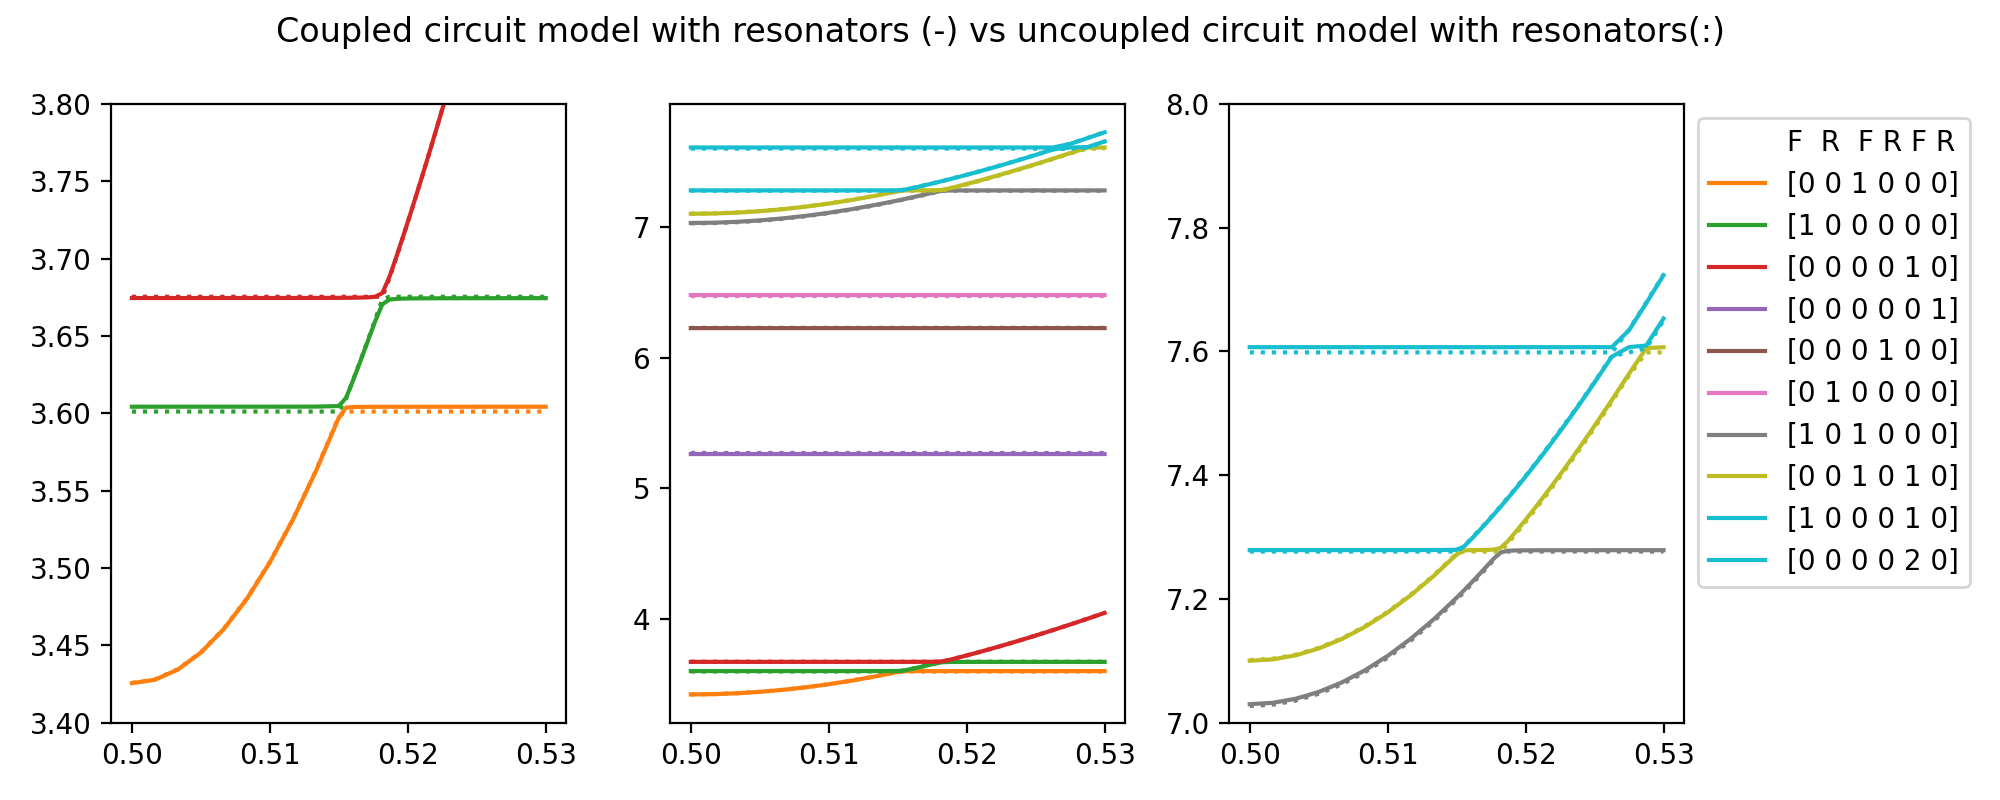

In [211]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = [10,4], dpi=200)

colors = figs.generate_colors_from_colormap(n_eig+3, 'tab10')

ax3.plot([], label='F  R  F R F R', color='white')
for i, color in enumerate(colors):
    if i ==0:
        continue
    for ax in [ax1, ax2, ax3]:
        ax.plot(φ_ext_2_values, E_circuits_full_A[:,i], color=color, label=N_circuits_full_A[0,i])
        ax.plot(φ_ext_2_values, E0_circuits_full_A[:,i], ':', color=color)
                       
ax3.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax1.set_ylim([3.4,3.8])
ax3.set_ylim([7,8])


fig.suptitle('Coupled circuit model with resonators (-) vs uncoupled circuit model with resonators(:)')
figs.export('Full model coupled vs uncoupled.pdf', fig)
# 
# ax2.set_ylim([7.2,7.6])
#ax.set_ylabel(r'$')
#ax.set_xlabel(r'$')
#ax.set_title(r'$')
fig.tight_layout()
fig.show()
plt.close('all')

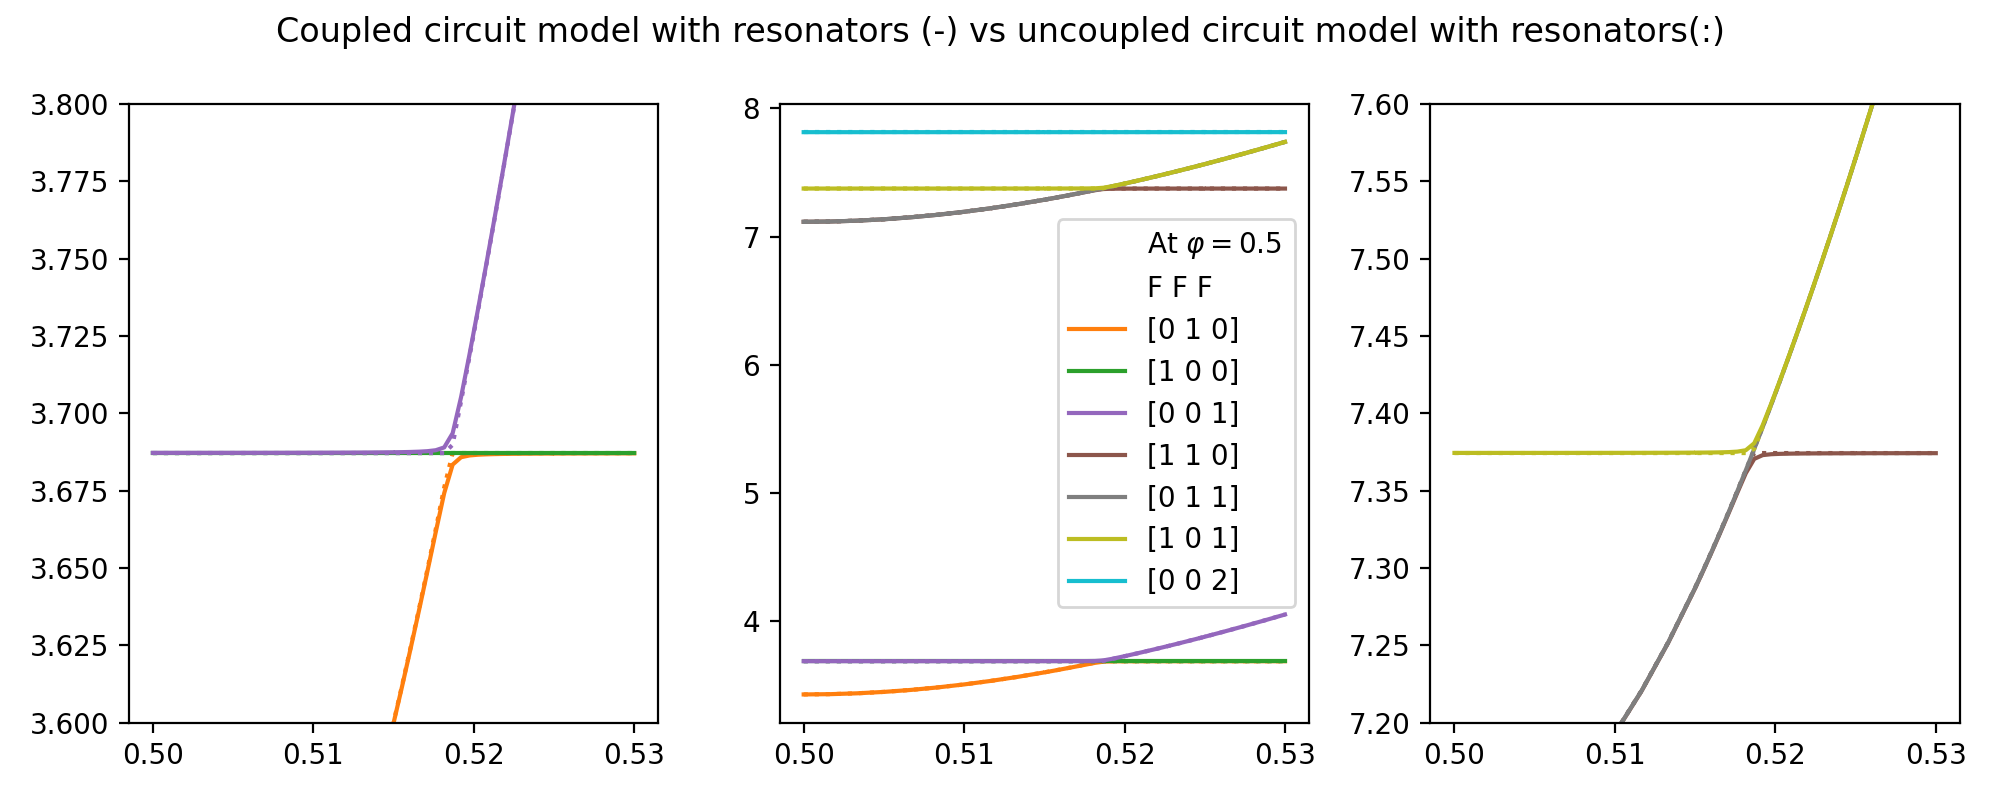

In [203]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = [10,4], dpi=200)

colors = figs.generate_colors_from_colormap(n_eig, 'tab10')

ax2.plot([], label=r'At $\varphi= 0.5$ ', color='white')
ax2.plot([], label='F F F ', color='white')
for i, color in enumerate(colors):
    if i ==0:
        continue
    for ax in [ax1, ax2, ax3]:
        ax.plot(φ_ext_2_values, E_circuits_nores_A[:,i], color=color, label=N_circuits_nores_A[0,i])
        ax.plot(φ_ext_2_values, E0_circuits_nores_A[:,i], ':', color=color)
                       
# ax2.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax2.legend()
ax1.set_ylim([3.6,3.8])
ax3.set_ylim([7.2,7.6])


fig.suptitle('Coupled circuit model with resonators (-) vs uncoupled circuit model with resonators(:)')
# 
# ax2.set_ylim([7.2,7.6])
#ax.set_ylabel(r'$')
#ax.set_xlabel(r'$')
#ax.set_title(r'$')
fig.tight_layout()
fig.show()
plt.close('all')

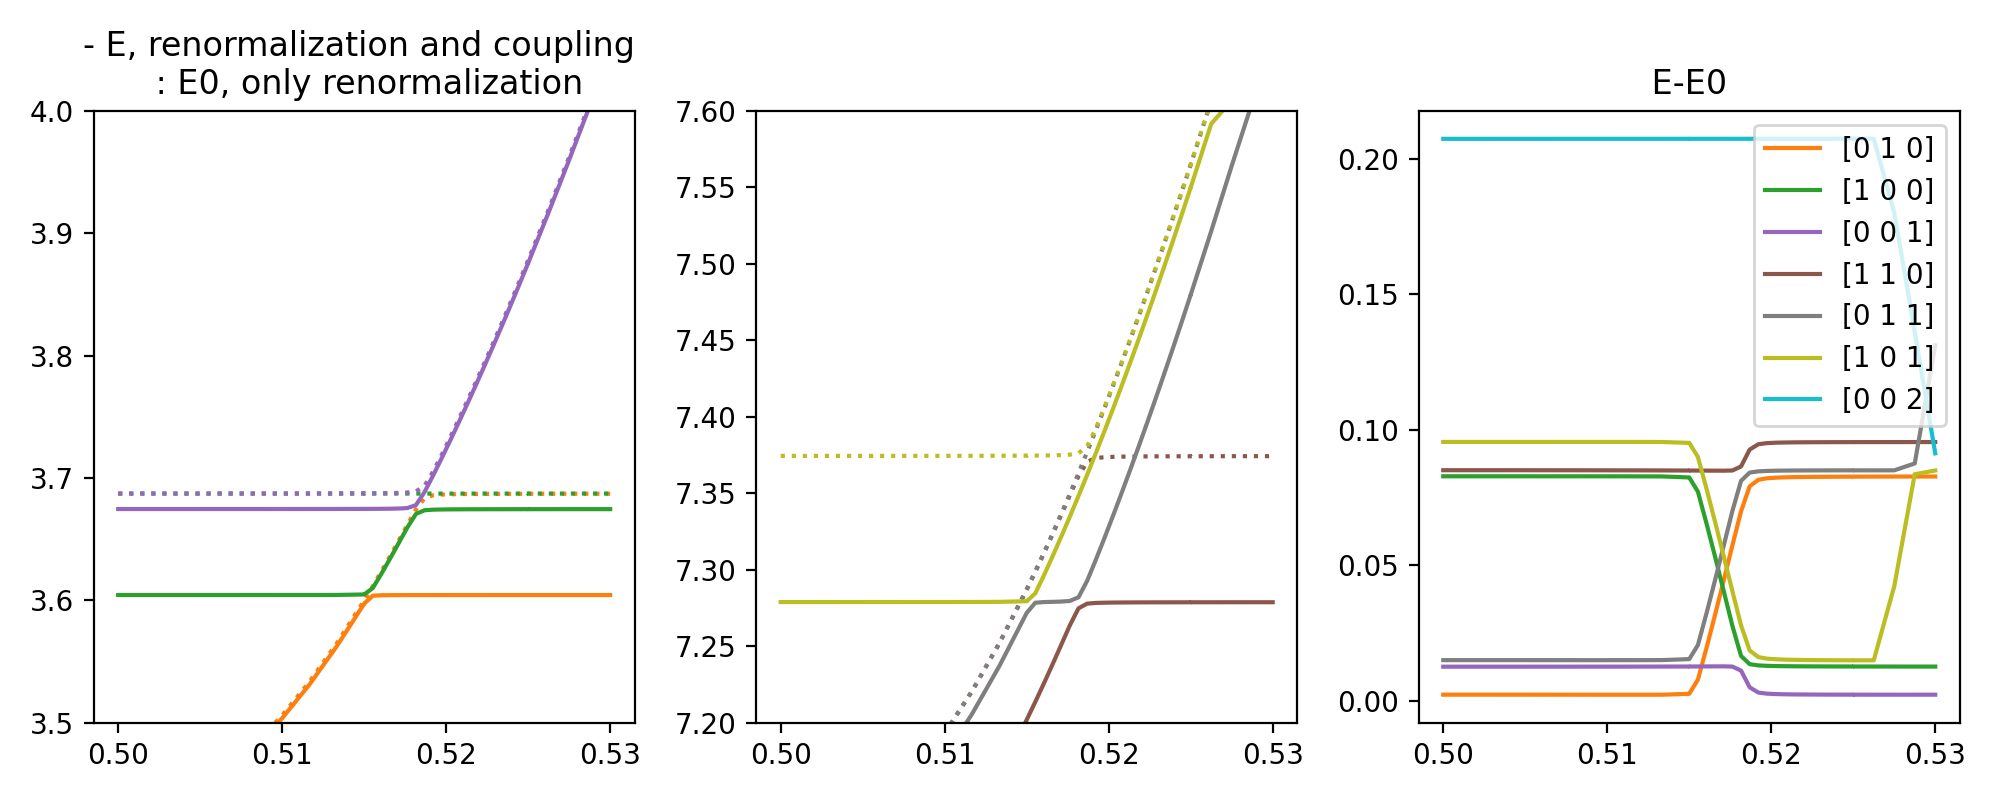

In [207]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = [10,4], dpi=200)

colors = figs.generate_colors_from_colormap(n_eig, 'tab10')

ax2.plot([], label=' F  F  F', color='white')
for i, color in enumerate(colors):
    if i ==0:
        continue
    for ax in [ax1, ax2, ax3]:
        if ax != ax3:
            circuit_full_index = np.where( np.all(N_circuits_full_A[0,:][:,[0,2,4]] == N_circuits_nores_A[0,i], axis=1) )[0][0]
            ax.plot(φ_ext_2_values, E_circuits_full_A[:,circuit_full_index], color=color)
            ax.plot(φ_ext_2_values, E_circuits_nores_A[:,i], ':', color=color)
        else:
            ax.plot(φ_ext_2_values, np.abs(E_circuits_nores_A[:,i]-E_circuits_full_A[:,circuit_full_index]), color=color, label=N_circuits_nores_A[0,i])
            
ax1.set_title('- E, renormalization and coupling \n : E0, only renormalization')            
ax3.set_title(' E-E0 ')            
            
ax3.legend(loc='upper right')

ax1.set_ylim([3.5,4])
ax2.set_ylim([7.2,7.6])
#ax.set_ylabel(r'$')
#ax.set_xlabel(r'$')
#ax.set_title(r'$')
fig.tight_layout()
fig.show()
plt.close('all')

## Assuming resonators can be neglected: Circuit model vs low energy model

In [118]:
CF_1, LF_1, EJ_1, _, _      = np.load(opt_dir +  '/qubit_1' + '.npz')['parameters_opt']
C_int_11, CR_1, LR_1, _, _  = np.load(opt_dir +  '/resonator_1' + '.npz')['parameters_opt']
CF_2, LF_2, EJ_2, _, _      = np.load(opt_dir +  '/qubit_2' + '.npz')['parameters_opt']
CR_2, LR_2, Δ_2, _, _       = np.load(opt_dir +  '/resonator_2' + '.npz')['parameters_opt']
CF_3, LF_3, EJ_3, _, _      = np.load(opt_dir +  '/qubit_3' + '.npz')['parameters_opt']
C_int_33, CR_3, LR_3, _, _  = np.load(opt_dir +  '/resonator_3' + '.npz')['parameters_opt']
C_int_12, _, _, _           = np.load(opt_dir +  '/qubit_1_qubit_2' + '.npz')['parameters_opt']
C_int_12, C_int_23, C_int_13, _, _, _, _, _, _, _, _, _= np.load(opt_dir +  '/qubit_1_qubit_2_qubit_3' + '.npz')['parameters_opt'] 
# C_int_23 = C_int_12
C_int_13 = 550000.000

In [119]:
C_diag       = [CF_1, CR_1, CF_2, CR_2, CF_3, CR_3  ]
C_int_diag   = [C_int_11, _, C_int_33               ]   
C_int        = [C_int_12, C_int_23, C_int_13        ]
C_inv_circuits_nores = sq_ext. C_mat_from_C_int(C_diag, C_int_diag, C_int, only_qubit_modes=True)

In [67]:
ω_q1, μ_q1, ω_q2, μ_q2, ω_q3, μ_q3, g_q1q2, g_q2q3, g_q1q3, _, _, shift_ω_q1q2 =\
                    np.load(opt_dir_low_ene +  '/qubit_1_qubit_2' + '.npz')['parameters_opt'] 
_, _, ω_q1, μ_q1 =  np.load(opt_dir_low_ene +  '/qubit_1' + '.npz')['parameters_opt']
_, _, ω_q2, μ_q2 =  np.load(opt_dir_low_ene +  '/qubit_2' + '.npz')['parameters_opt']
_, _, ω_q3, μ_q3 =  np.load(opt_dir_low_ene +  '/qubit_3' + '.npz')['parameters_opt']

g_list = [g_q1q2, g_q2q3, g_q1q3]

In [134]:
φ_ext_2_values = np.concatenate((np.linspace(0.51, 0.515, 5), np.linspace(0.515, 0.525, 20), np.linspace(0.525, 0.53, 5)))
# φ_ext_2_values = np.linspace(0.49,0.51)
nmax_f = 15
nmax_r = 6
n_eig = 8
n_eig_individual = 3

E_circuits_nores  = np.zeros([len(φ_ext_2_values), n_eig])
E0_circuits_nores = np.zeros([len(φ_ext_2_values), n_eig_individual**3])
N_circuits_nores  = np.zeros([len(φ_ext_2_values), n_eig_individual**3, 3], dtype='int')
E_low_energy      = np.zeros([len(φ_ext_2_values), n_eig])

fluxonium_1 = sq_ext.sq_fluxonium(C_F_eff=C_inv_circuits_nores[0, 0] ** -1, L_F_eff = LF_1, EJ=EJ_1, nmax_f=nmax_f)
fluxonium_3 = sq_ext.sq_fluxonium(C_F_eff=C_inv_circuits_nores[2, 2] ** -1, L_F_eff = LF_3, EJ=EJ_3, nmax_f=nmax_f)
φ_ext_3_resonance = sq_ext.find_resonance(fluxonium_1.hamiltonian(), fluxonium_3)
loop_3 = fluxonium_3.loops[0]
loop_3.set_flux(φ_ext_3_resonance)

H_1 = sq_ext.hamiltonian_fluxonium_low_ene(ω_q1, μ_q1, φ_ext=0.5)
φ_ext_resonance_q1q3 = sq_ext.find_resonance_low_energy(H_1, sq_ext.hamiltonian_fluxonium_low_ene, [ω_q3, μ_q3])
H_3 = sq_ext.hamiltonian_fluxonium_low_ene(ω_q3, μ_q3, φ_ext_resonance_q1q3)

for i, φ_ext_2 in enumerate(φ_ext_2_values):
    
    print(i)
    
    fluxonium_2 = sq_ext.sq_fluxonium(C_F_eff=C_inv_circuits_nores[1, 1] ** -1, L_F_eff = LF_2, EJ=EJ_2, nmax_f=nmax_f, φ_ext=φ_ext_2)
    H_2 = sq_ext.hamiltonian_fluxonium_low_ene(ω_q2, μ_q2, φ_ext_2)
    H_low_ene_list = [H_1, H_2, H_3]

    circuits_nores = [fluxonium_1, fluxonium_2, fluxonium_3]
    H_circuits = [circuit.hamiltonian() for circuit in circuits_nores]
    
    E_indiv_circuits_nores = np.array([sq_ext.diag(H, n_eig_individual, solver='numpy', remove_ground=True)[0] for H in H_circuits])
    
    E0_circuits_nores[i,:], N_circuits_nores [i,:] = sq_ext.combine_eigenvalues(E_indiv_circuits_nores)
    
    H_circuits_nores = sq_ext.hamiltonian_fluxonium_C_fluxonium_C_fluxonium(C_inv_circuits_nores, circuits_nores, nmax_f=nmax_f, return_H_0=False)
    H_low_energy = sq_ext.hamiltonian_fluxonium_C_fluxonium_C_fluxonium_low_ene(H_low_ene_list, g_list)
    
    E_circuits_nores[i,:] = sq_ext.diag(H_circuits_nores, n_eig,  remove_ground=True)[0]
    E_low_energy[i,:] = sq_ext.diag(H_low_energy, n_eig, solver='numpy', out=None,  remove_ground=True)[0] / GHz

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


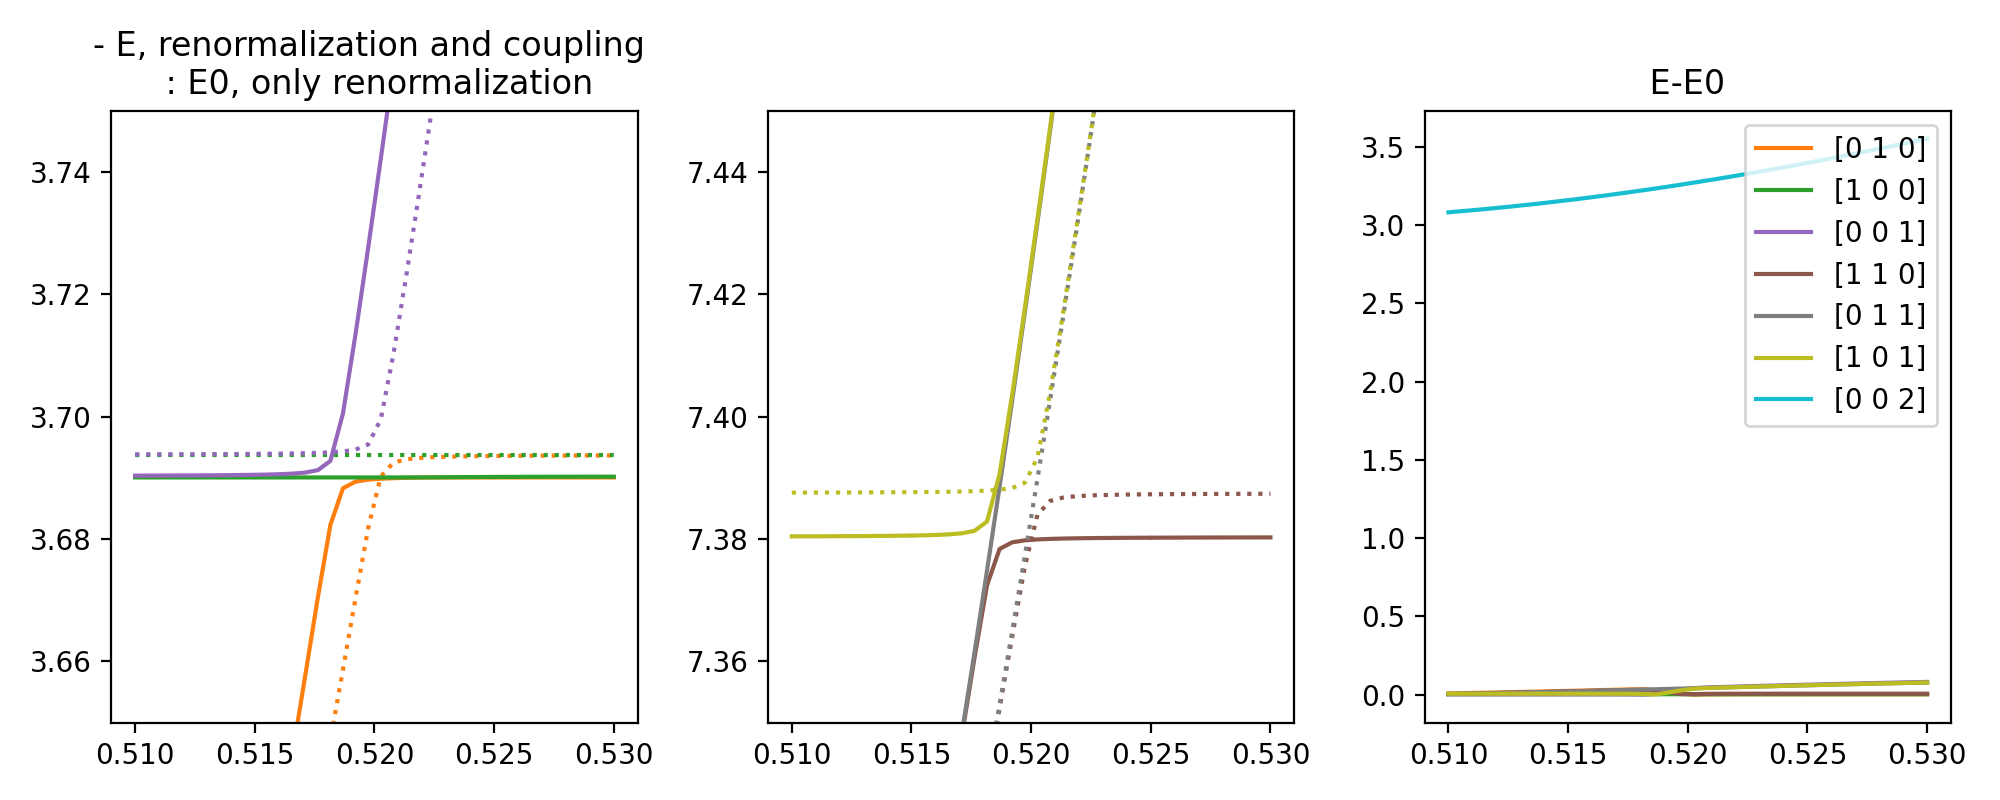

In [135]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = [10,4], dpi=200)

colors = figs.generate_colors_from_colormap(n_eig, 'tab10')

ax2.plot([], label=' F  F  F', color='white')
for i, color in enumerate(colors):
    if i ==0:
        continue
    for ax in [ax1, ax2, ax3]:
        if ax != ax3:
            ax.plot(φ_ext_2_values, E_circuits_nores[:,i], color=color)
            ax.plot(φ_ext_2_values, E_low_energy[:,i], ':', color=color)
        else:
            ax.plot(φ_ext_2_values, np.abs(E_circuits_nores[:,i]-E_low_energy[:,i]), color=color, label=N_circuits_nores[0,i])
            
ax1.set_title('- E, renormalization and coupling \n : E0, only renormalization')            
ax3.set_title(' E-E0 ')            
            
ax3.legend(loc='upper right')

# ax1.set_ylim([3.4,3.6])
# ax3.set_ylim([0,0.01])
ax1.set_ylim([3.65,3.75])
ax2.set_ylim([7.35,7.45])
#ax.set_ylabel(r'$')
#ax.set_xlabel(r'$')
#ax.set_title(r'$')
fig.tight_layout()
fig.show()
plt.close('all')

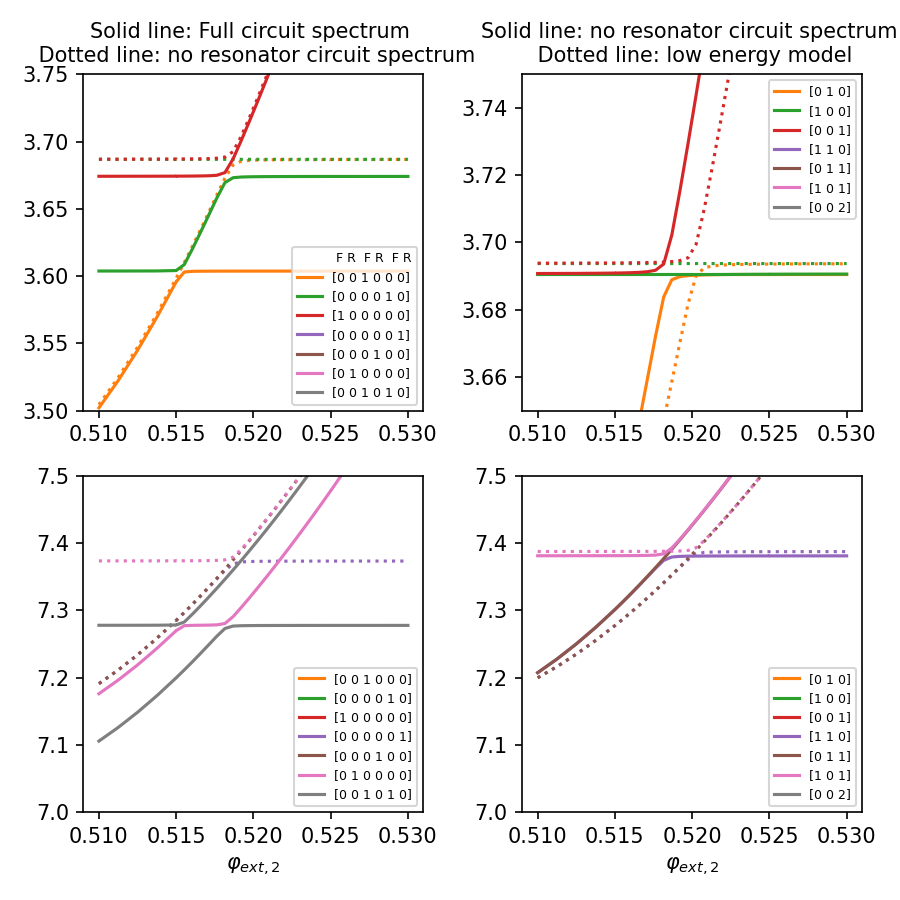

In [117]:
 fig, axs = plt.subplots(ncols=2, nrows=2, figsize = [6,6], dpi=150)

colors = figs.generate_colors_from_colormap(n_eig+2, 'tab10')

axs[0,0].plot([], label=' F R  F R  F R', color='white')
for i, color in enumerate(colors):
    if i ==0:
        continue
    for k in range(2):    
        if i < n_eig:
            axs[k,0].plot(φ_ext_2_values, E_circuits_full_A[:,i], color=color, label = N_circuits_full_A[0,i])
            axs[k,0].plot(φ_ext_2_values, E_circuits_nores_A[:,i], ':', color=color)
            axs[k,1].plot(φ_ext_2_values, E_circuits_nores[:,i], color=color,label = N_circuits_nores[0,i])
            axs[k,1].plot(φ_ext_2_values, E_low_energy[:,i], ':', color=color)
        else:
            axs[k,0].plot(φ_ext_2_values, E_circuits_full_A[:,i], color=colors[i-2])
            
    
[ ax.legend(fontsize=6) for ax in axs.flatten()]        
axs[0,0].set_title('Solid line: Full circuit spectrum \n Dotted line: no resonator circuit spectrum', fontsize=10)           
axs[0,1].set_title('Solid line: no resonator circuit spectrum \n Dotted line: low energy model', fontsize=10)           
# ax3.legend(loc='upper right')
axs[0,0].set_ylim([3.5,3.75])
axs[0,1].set_ylim([3.65,3.75])
axs[1,0].set_ylim([7,7.5])
axs[1,1].set_ylim([7,7.5])
axs[1,0].set_xlabel(r'$\varphi_{ext,2}$')
axs[1,1].set_xlabel(r'$\varphi_{ext,2}$')
#ax.set_ylabel(r'$')
#ax.set_xlabel(r'$')
#ax.set_title(r'$')
fig.tight_layout()
fig.show()
plt.close('all')

# Qubit 1 - Coupler at operation point

In [73]:
n_eig = 8
nmax_r = 3
nmax_f = 7

CC_values = np.geomspace(1e-5, 1e0, 10)

In [52]:
nmax_r = 4
nmax_f = 10
n_eig_full = 4

In [127]:
p1  = np.zeros([len(CC_values), 4, 4])
p2  = np.zeros([len(CC_values), 4, 4])
SWT = np.zeros([len(CC_values), 4, 4])

g_r_limit =np.zeros(len(CC_values))
g_fq_limit=np.zeros(len(CC_values))

for i, CC in enumerate(CC_values):
    print(i)

    C_mat = sq_ext.C_mat_qubit_C_qubit(CC, CR_1, CF_1, CR_2, CF_2, only_inner=True, compensate_extra_cap=False, only_renormalization=False)
    C_inv = np.linalg.inv(C_mat)
    
    fluxonium_1 = sq_ext.sq_fluxonium(C_F_eff=C_inv[0, 0] ** -1, L_F_eff = LF_1, EJ=EJ_1, nmax_f=nmax_f, φ_ext = φ_ext_1)
    resonator_1 = sq_ext.sq_resonator(C_R_eff=C_inv[1, 1] ** -1, L_R_eff = LR_1, nmax_r=nmax_r)
    fluxonium_2 = sq_ext.sq_fluxonium(C_F_eff=C_inv[2, 2] ** -1, L_F_eff = LF_2, EJ=EJ_1, nmax_f=nmax_f, φ_ext = φ_ext_2)
    resonator_2 = sq_ext.sq_resonator(C_R_eff=C_inv[3, 3] ** -1, L_R_eff = LR_2, nmax_r=nmax_r)
    
    circuits = [fluxonium_1, resonator_1, fluxonium_2, resonator_2]
    Δs = [Δ_1, Δ_2]
    
    H_f1 = fluxonium_1.hamiltonian()
    H_r1 = resonator_1.hamiltonian()
    H_f2 = fluxonium_2.hamiltonian()
    H_r2 = resonator_2.hamiltonian()
    H_q1 = sq_ext.hamiltonian_qubit(fluxonium_1, resonator_1, Δ_1)
    H_q2 = sq_ext.hamiltonian_qubit(fluxonium_2, resonator_2, Δ_2)
    
    Nf, Nr = sq_ext.sq_get_energy_indices_hamiltonian(H_qubit = H_q1, H_fluxonium=H_f1, H_resonator=H_r1)
    subspace_indices = np.intersect1d(np.where(Nf<=1), np.where(Nr==0)).tolist()
    index_00_q1 = np.intersect1d(np.where(Nf==0), np.where(Nr==0)).tolist()[0]
    index_10_q1 = np.intersect1d(np.where(Nf==1), np.where(Nr==0)).tolist()[0]
    
    Nf, Nr = sq_ext.sq_get_energy_indices_hamiltonian(H_qubit = H_q2, H_fluxonium=H_f2, H_resonator=H_r2)
    subspace_indices = np.intersect1d(np.where(Nf<=1), np.where(Nr==0)).tolist()
    index_00_q2 = np.intersect1d(np.where(Nf==0), np.where(Nr==0)).tolist()[0]
    index_10_q2 = np.intersect1d(np.where(Nf==1), np.where(Nr==0)).tolist()[0]

    ψ_00_q1 = qt.Qobj(sq_ext.diag(H_q1,n_eig=4,solver='numpy')[1][:,index_00_q1]) 
    ψ_10_q1 = qt.Qobj(sq_ext.diag(H_q1,n_eig=4,solver='numpy')[1][:,index_10_q1]) 
    ψ_00_q2 = qt.Qobj(sq_ext.diag(H_q2,n_eig=4,solver='numpy')[1][:,index_00_q2]) 
    ψ_10_q2 = qt.Qobj(sq_ext.diag(H_q2,n_eig=4,solver='numpy')[1][:,index_10_q2]) 
    
    ψ_00_q1.dims = [[nmax_f, nmax_r],[1,1]]
    ψ_10_q1.dims = [[nmax_f, nmax_r],[1,1]]
    ψ_00_q2.dims = [[nmax_f, nmax_r],[1,1]]
    ψ_10_q2.dims = [[nmax_f, nmax_r],[1,1]]
    
    ψ_00 = qt.tensor([ψ_00_q1, ψ_00_q2])
    ψ_01 = qt.tensor([ψ_10_q1, ψ_00_q2])
    ψ_10 = qt.tensor([ψ_00_q1, ψ_10_q2])
    ψ_11 = qt.tensor([ψ_10_q1, ψ_10_q2])
    
    ψ_0 = [ψ_00,ψ_01,ψ_10,ψ_11]
    
    
    H_0, H   = sq_ext.hamiltonian_qubit_C_qubit_circuits(C_inv, circuits, Δs, nmax_r=nmax_r, nmax_f=nmax_f, return_H_0=True)
        
    E_0_ψ_0  = [ np.real((ψ_0_i.dag() * H_0 * ψ_0_i).data[0,0])/2/np.pi/GHz for ψ_0_i in ψ_0]
    E_0  = sq_ext.diag(H_0  , n_eig=len(ψ_0)+n_eig_full, out='GHz', solver='scipy')[0]
    subspace_indices = sq_ext.find_close_indices(E_0_ψ_0, E_0)
    print(E_0_ψ_0,E_0)
    print(subspace_indices)
        # subspace_indices = sq_ext.find_close_indices(E_0_ψ_0, E_0)
    # Nf, Nr = sq_ext.sq_get_energy_indices_hamiltonian(H_qubit = H_0, H_fluxonium=H_f1, H_resonator=H_f2, n_eig=n_eig)
    # subspace_indices = np.intersect1d(np.where(Nf<=1), np.where(Nr<=1)).tolist()
    
    E, ψ = sq_ext.diag(H  , n_eig=len(ψ_0)+n_eig_full, out='GHz', solver='Qutip', qObj=True)
    ψ = ψ[subspace_indices]
    E = E[subspace_indices]
    V = H-H_0
    
    H_eff_p1  = sq_ext.H_eff_p1_large (ψ_0, H, real=True, remove_ground=True)
    H_eff_p2  = sq_ext.H_eff_p2_large (ψ_0, ψ, E_0, E, V,  remove_ground=True)
    H_eff_SWT = sq_ext.H_eff_SWT_large(ψ_0, ψ, E, remove_ground=True)

    
    p1 [i,:] = sq_ext.decomposition_in_pauli_4x4(H_eff_p1  ,  print_pretty=False)
    p2 [i,:] = sq_ext.decomposition_in_pauli_4x4(H_eff_p2  ,  print_pretty=False)
    SWT[i,:] = sq_ext.decomposition_in_pauli_4x4(H_eff_SWT , print_pretty=False)

0
[9.499679863977692, 13.188144475754253, 14.455249480703548, 18.14371409248014] [9.499679863978 13.188144475754 14.455249480704 17.593894498870 18.143714092480 20.227774777648 22.424339669531 22.549464115596]
[0, 1, 2, 4]
1
[9.499753780165856, 13.188104239958756, 14.4551115099762, 18.143461969769096] [9.499753780166 13.188104239959 14.455111509977 17.593714779129 18.143461969769 20.227383274479 22.424007598092 22.549072508939]
[0, 1, 2, 4]
2
[9.499876887332785, 13.188037233261007, 14.454881726723547, 18.14304207265178] [9.499876887333 13.188037233261 14.454881726724 17.593415469607 18.143042072652 20.226731241777 22.423454555017 22.548420308998]
[0, 1, 2, 4]
3
[9.500081708621737, 13.187925766221632, 14.45449943969212, 18.14234349729202] [9.500081708622 13.187925766222 14.454499439692 17.592917525471 18.142343497292 20.225646453395 22.422534479409 22.547335256541]
[0, 1, 2, 4]
4
[9.500421893549992, 13.187740677109941, 14.453864554262482, 18.141183337822444] [9.500421893550 13.187740677

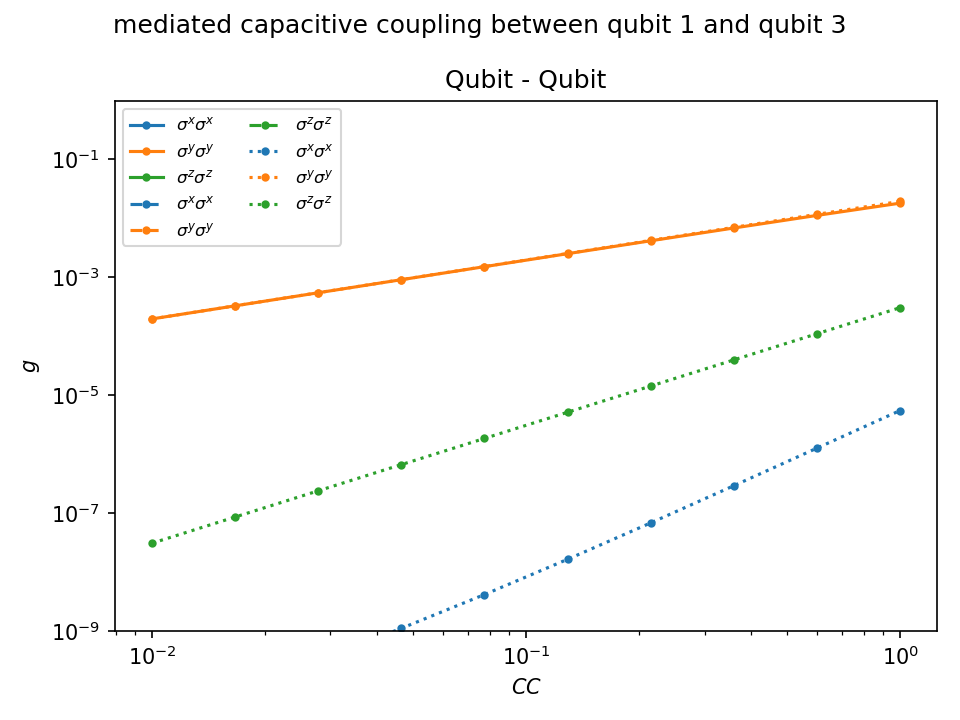

In [128]:
fig, ax = plt.subplots(dpi=150)
linestyles = ['-', '--',':' ]
names = ['Qubit - Qubit','Qubit - Resonator','Resonator - Resonator']
labels_list =[[r'$\sigma^x\sigma^x$',r'$\sigma^y\sigma^y$',r'$\sigma^z\sigma^z$'],
              [r'$\sigma^x\,(b^\dagger+b)$',r'$\sigma^y\,(b^\dagger-b)j$',r'$\sigma^z(2b^\dagger b-I)$'],
              [r'$(a^\dagger+a)\,(b^\dagger+b)$',r'$(a^\dagger-a)j\,(b^\dagger-b)j$',r'$(2a^\dagger a-I)(2b^\dagger b-I)$']]

labels = labels_list[0]
name = names[0]
colors = figs.generate_colors_from_colormap(10, 'tab10')
Pauli_list = [p1, p2, SWT]

for i, Pauli in enumerate(Pauli_list):
    # if i ==1: 
    #     continue
    
    σxσx = np.abs(Pauli[:, 1,1])
    σyσy = np.abs(Pauli[:, 2,2])
    σzσz = np.abs(Pauli[:, 3,3])

    ax.plot(CC_values, σxσx,'.', color = colors[0], linestyle=linestyles[i], label = labels[0])
    ax.plot(CC_values, σyσy,'.', color = colors[1], linestyle=linestyles[i], label = labels[1])
    ax.plot(CC_values, σzσz,'.', color = colors[2], linestyle=linestyles[i], label = labels[2])

    ax.legend(ncol=2, fontsize=8)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim([1e-9,1e0])
    # ax.set_xlim([1e-2,1e1])
    ax.set_ylabel('$g$')
    ax.set_xlabel('$CC$')
    
    ax.set_title(name)
    
fig.suptitle(r'mediated capacitive coupling between qubit 1 and qubit 3')
fig.tight_layout()
# figs.export('mediated_capacitive_coupling_vs_CC_qubit_1_and_qubit_3.pdf', fig)
fig.show()

# Qubit_1 - Qubit_3, mediated by Qubit 2, vs CC

In [76]:
Δs = [Δ_1, Δ_2, Δ_3]
nmax_f = 7
nmax_r = 4

In [77]:
CC_values = np.geomspace(1e-3, 1e0, 10)

In [78]:
basis_states_q1_list = [ [(0,0), (1,0)], [(0,0), (1,0)], [(0,0), (0,1)] ]
basis_states_q2_list = [ [(0,0), (1,0)], [(0,0), (1,0)], [(0,0), (1,0)] ]
basis_states_q3_list = [ [(0,0), (1,0)], [(0,0), (0,1)], [(0,0), (0,1)] ]

In [79]:
left_index_list     = [0, 0, 1]
mediator_index_list = [2, 2, 2]
right_index_list    = [4, 5, 5]

In [80]:
extra_eigs_list = [5, 12, 30]

In [81]:
p1              = np.zeros([3, len(CC_values), 4, 4])
p2              = np.zeros([3, len(CC_values), 4, 4])
SWT             = np.zeros([3, len(CC_values), 4, 4])
Qs              = np.zeros([3, len(CC_values), 4, 4], dtype='complex')
g_13_analytic   = np.zeros([3, len(CC_values)])

for i, CC in enumerate(CC_values):
    print(i)

    C_mat = sq_ext.C_mat_qubit_C_qubit_C_qubit(CC, CF_1, CR_1, CF_2, CR_2, CF_3, CR_3)
    C_inv = np.linalg.inv(C_mat)
    
    fluxonium_1 = sq_ext.sq_fluxonium(C_F_eff=C_inv[0, 0] ** -1, L_F_eff = LF_1, EJ=EJ_1, nmax_f=nmax_f)
    resonator_1 = sq_ext.sq_resonator(C_R_eff=C_inv[1, 1] ** -1, L_R_eff = LR_1, nmax_r=nmax_r)
    fluxonium_2 = sq_ext.sq_fluxonium(C_F_eff=C_inv[2, 2] ** -1, L_F_eff = LF_2, EJ=EJ_2, nmax_f=nmax_f)
    resonator_2 = sq_ext.sq_resonator(C_R_eff=C_inv[3, 3] ** -1, L_R_eff = LR_2, nmax_r=nmax_r)
    fluxonium_3 = sq_ext.sq_fluxonium(C_F_eff=C_inv[4, 4] ** -1, L_F_eff = LF_3, EJ=EJ_3, nmax_f=nmax_f)
    resonator_3 = sq_ext.sq_resonator(C_R_eff=C_inv[5, 5] ** -1, L_R_eff = LR_3, nmax_r=nmax_r)
    
    circuits = [fluxonium_1, resonator_1, fluxonium_2, resonator_2, fluxonium_3, resonator_3]
    
    H_circuits = [circuit.hamiltonian() for circuit in circuits]
    E_circuits = [sq_ext.diag(H, 2, solver='numpy')[0] for H in H_circuits]
    
    H_qubit_1 = sq_ext.hamiltonian_qubit(fluxonium_1, resonator_1, Δs[0] )
    H_qubit_2 = sq_ext.hamiltonian_qubit(fluxonium_2, resonator_2, Δs[1] )
    H_qubit_3 = sq_ext.hamiltonian_qubit(fluxonium_3, resonator_3, Δs[2] )
    
    H_0, H   = sq_ext.hamiltonian_qubit_C_qubit_C_qubit(C_inv, circuits, Δs, nmax_r=nmax_r, nmax_f=nmax_f, return_H_0=True)
    
    for j in range(3):
        # Composite method    
        ψ_0_q1, ψ_1_q1, index_0_q1, index_1_q1 = sq_ext.get_ψ_basis(basis_states_q1_list[j], H_qubit_1, E_circuits[0], E_circuits[1], nmax_f, nmax_r)
        ψ_0_q2, ψ_1_q2, index_0_q2, index_1_q2 = sq_ext.get_ψ_basis(basis_states_q2_list[j], H_qubit_2, E_circuits[2], E_circuits[3], nmax_f, nmax_r)
        ψ_0_q3, ψ_1_q3, index_0_q3, index_1_q3 = sq_ext.get_ψ_basis(basis_states_q3_list[j], H_qubit_3, E_circuits[4], E_circuits[5], nmax_f, nmax_r)
    
        ψ_00 = qt.tensor([ψ_0_q1, ψ_0_q2, ψ_0_q3])
        ψ_01 = qt.tensor([ψ_1_q1, ψ_0_q2, ψ_0_q3])
        ψ_10 = qt.tensor([ψ_0_q1, ψ_0_q2, ψ_1_q3])
        ψ_11 = qt.tensor([ψ_1_q1, ψ_0_q2, ψ_1_q3])
    
        ψ_0 = [ψ_00,ψ_01,ψ_10,ψ_11]
        
        E_0_ψ_0  = [ np.real((ψ_0_i.dag() * H_0 * ψ_0_i).data[0,0])/2/np.pi/GHz for ψ_0_i in ψ_0]
        E_0  = sq_ext.diag(H_0 , n_eig=len(ψ_0)+extra_eigs_list[j], out='GHz', solver='scipy')[0]
        print(E_0_ψ_0, E_0)
        subspace_indices = sq_ext.find_close_indices(E_0_ψ_0, E_0)
        print(subspace_indices)
        print('/n')
        
        E, ψ = sq_ext.diag(H  , n_eig=len(ψ_0)+extra_eigs_list[j], out='GHz', solver='Qutip', qObj=True)
        ψ = ψ[subspace_indices]
        E = E[subspace_indices]
        # V = H-H_0
        
        H_eff_p1  = sq_ext.H_eff_p1_large (ψ_0, H, real=True, remove_ground=True)
        # H_eff_p2  = sq_ext.H_eff_p2_large (ψ_0, ψ, E_0, E, V,  remove_ground=True)
        H_eff_SWT, Qs[j, i,:] = sq_ext.H_eff_SWT_large(ψ_0, ψ, E, remove_ground=True,return_Q=True)
    
    
        p1 [j, i,:] = sq_ext.decomposition_in_pauli_4x4(H_eff_p1  ,  print_pretty=False)
        # p2 [i,:] = sq_ext.decomposition_in_pauli_4x4(H_eff_p2  ,  print_pretty=False)
        SWT[j, i,:] = sq_ext.decomposition_in_pauli_4x4(H_eff_SWT , print_pretty=False)
    
        #Analytics:
        circ_1, circ_2, circ_3 = circuits[left_index_list[j]], circuits[mediator_index_list[j]], circuits[right_index_list[j]]
        circ_1.diag(2)[0];
        circ_2.diag(2)[0];
        circ_3.diag(2)[0];
        Q_1 = np.abs(circ_1.charge_op(0, basis='eig')[0,1])
        Q_2 = np.abs(circ_2.charge_op(0, basis='eig')[0,1])
        Q_3 = np.abs(circ_3.charge_op(0, basis='eig')[0,1])
        
        
        E_1 = sq_ext.diag(H_qubit_1,4)[0]
        E_2 = sq_ext.diag(H_qubit_2,4)[0]
        E_3 = sq_ext.diag(H_qubit_3,4)[0]
        
        ω_1 = E_1[index_1_q1]- E_1[index_0_q1]
        ω_2 = E_2[index_1_q2]- E_2[index_0_q2]
        ω_3 = E_3[index_1_q3]- E_3[index_0_q3]
        
    
        Δ_12 = -np.abs(ω_1 - ω_2) # maybe change sign
        Δ_23 = -np.abs(ω_3 - ω_2) 
        Σ_12 = ω_1 + ω_2
        Σ_23 = ω_3 + ω_2
    
        g_12 = C_inv[left_index_list[j],mediator_index_list[j]] * fF**-1 * Q_1 * Q_2 /2/np.pi/GHz
        g_23 = C_inv[mediator_index_list[j],right_index_list[j]] * fF**-1 * Q_2 * Q_3 /2/np.pi/GHz
        g_13 = C_inv[left_index_list[j],right_index_list[j]] * fF**-1 * Q_1 * Q_3 /2/np.pi/GHz
    
        g_eff = g_12*g_23*(1/Δ_12 + 1/Δ_23 - 1/Σ_12-1/Σ_23) + g_13
    
        g_13_analytic[j, i] = g_eff
    

0
[15.639598096588838, 19.318628849708936, 18.66916734664902, 22.348198099769057] [15.639598096589 18.669167346649 19.062314387025 19.318628849709 20.889010957877 21.914833738305 22.091883637086 22.105800793495 22.348198099769]
[0, 3, 1, 8]
/n


C:\Users\gabri\PycharmProjects\tunable-capacitive-coupling-flux-qubits\Modules\SQcircuit_extensions.py:1630: ComplexWarning: Casting complex values to real discards the imaginary part
  


[15.639598096588838, 19.318628849708936, 20.889010957876437, 24.568041710996543] [15.639598096589 18.669167346649 19.062314387025 19.318628849709 20.889010957877 21.914833738305 22.091883637086 22.105800793495 22.348198099769 22.741345140146 22.777536112096 23.712255555829 23.962654552068 24.146245085131 24.311727248313 24.568041710997]
[0, 3, 4, 15]
/n
[15.639598096588838, 22.105800793494968, 20.889010957876437, 27.355213654782446] [15.639598096589 18.669167346649 19.062314387026 19.318628849709 20.889010957878 21.914833738305 22.091883637085 22.105800793495 22.348198099769 22.741345140145 22.777536112096 23.712255555829 23.962654552068 24.146245085131 24.311727248313 24.568041710997 24.944402988365 25.135370043555
 25.340671887564 25.528517083931 25.593864491425 25.770914390206 25.788061792578 26.138820824351 26.200252402532 26.456566865216 26.741824805889 27.134971846265 27.164246599592 27.175814335191 27.282255359978 27.355213654783 27.385370842504 27.641685305188]
[0, 7, 4, 31]
/n

In [85]:
H_qubit_1 = sq_ext.hamiltonian_qubit(fluxonium_1, resonator_1, Δs[0] )
H_qubit_2 = sq_ext.hamiltonian_qubit(fluxonium_2, resonator_2, Δs[1] )
H_qubit_3 = sq_ext.hamiltonian_qubit(fluxonium_3, resonator_3, Δs[2] )

In [86]:
H_qubits = [H_qubit_1, H_qubit_2, H_qubit_3]

In [96]:
E_ψ_qubits = [sq_ext.diag(H, 4, solver='numpy') for H in H_qubits]

In [97]:
E_qubits = [E_ψ_qubit[0] for E_ψ_qubit in E_ψ_qubits]
ψ_qubits = [E_ψ_qubit[1] for E_ψ_qubit in E_ψ_qubits]

In [98]:
eigvals_A, eigvals_B, eigvals_C = E_qubits
eigvecs_A, eigvecs_B, eigvecs_C = ψ_qubits

In [99]:
E_0, ψ_0 = sq_ext.compute_combined_eigenstates_3_body(E_qubits, ψ_qubits, nmax_f, nmax_r)

In [100]:
E_0_ψ_0  = [ np.real((ψ_0_i.dag() * H_0 * ψ_0_i).data[0,0])/2/np.pi/GHz for ψ_0_i in ψ_0]

In [103]:
E_0  = sq_ext.diag(H_0 , n_eig=20, out='GHz', solver='scipy')[0]

In [108]:
k=12
np.all(np.isclose(np.abs(E_0_ψ_0[:k]-E_0[:k]),0))

True

In [110]:
E, ψ = sq_ext.diag(H  , n_eig=k, out='GHz', solver='Qutip', qObj=True)

In [111]:
sq_ext.H_eff_p1_large (ψ_0, H, real=True, remove_ground=True)

array([[0.000000000000, 0.000000000000, 0.000000000000, 0.000000000000, 0.000000000000, 0.000000000000, 0.000000000000, 0.013114409218, -0.000307847599, -0.016186848962, -0.007369384334, 0.002860622579],
       [0.000000000000, 3.016321538473, -0.013114409218, 0.000307847599, 0.026373377603, -0.030656855763, 0.000740395541, 0.000000000000, 0.000000000000, 0.000000000000, 0.000000000000, 0.000000000000],
       [0.000000000000, -0.013114409218, 3.370149810182, 0.016186848962, 0.035488036442, -0.000355401917, 0.038930532013, 0.000000000000, 0.000000000000, 0.000000000000, 0.000000000000, 0.000000000000],
       [0.000000000000, 0.000307847599, 0.016186848962, 3.660065588028, -0.000833046051, -0.043083258219, -0.035856905764, 0.000000000000, 0.000000000000, 0.000000000000, 0.000000000000, 0.000000000000],
       [0.000000000000, 0.026373377603, 0.035488036442, -0.000833046051, 5.186410049820, 0.082958492175, -0.002003535464, 0.000000000000, 0.000000000000, 0.000000000000, 0.000000000000, 

In [119]:
sq_ext.H_eff_p1_large (ψ_0, H, real=True, remove_ground=True)

array([[0.000000000000, -0.013114409218, 0.000307847599, 0.026373377603],
       [-0.013114409218, 0.353828271709, 0.016186848962, 0.035488036442],
       [0.000307847599, 0.016186848962, 0.643744049555, -0.000833046051],
       [0.026373377603, 0.035488036442, -0.000833046051, 2.170088511347]])

In [114]:
np.real(sq_ext.H_eff_SWT_large(ψ_0, ψ, E, remove_ground=True,return_Q=False))

array([[0.000000000000, -0.000000000000, 0.000000000000, -0.000000000000, -0.000000000000, -0.000000000000, 0.000000000000, 0.013750127529, 0.000368171383, -0.016835482134, -0.006569907927, 0.004557984291],
       [-0.000000000000, 3.015903552872, -0.013221615786, 0.000203714582, 0.026724901631, -0.030871939779, 0.000513782915, -0.000000000000, 0.000000000000, 0.000000000000, -0.000000000000, -0.000000000000],
       [0.000000000000, -0.013221615786, 3.369511353814, 0.016339656453, 0.035590124065, -0.000257686980, 0.038993504312, -0.000000000000, 0.000000000000, -0.000000000000, -0.000000000000, -0.000000000000],
       [-0.000000000000, 0.000203714582, 0.016339656453, 3.659540757025, -0.000576750963, -0.043440212494, -0.036355102007, 0.000000000000, -0.000000000000, 0.000000000000, 0.000000000000, 0.000000000000],
       [-0.000000000000, 0.026724901631, 0.035590124065, -0.000576750963, 5.185444833703, 0.083144403135, -0.001451900210, 0.000000000000, -0.000000000000, 0.000000000000, 0

In [118]:
ψ_0 = ψ_0[1:5]
ψ = ψ[1:5]
E = E[1:5]

In [ ]:

subspace_indices = sq_ext.find_close_indices(E_0_ψ_0, E_0)
print(subspace_indices)
print('/n')

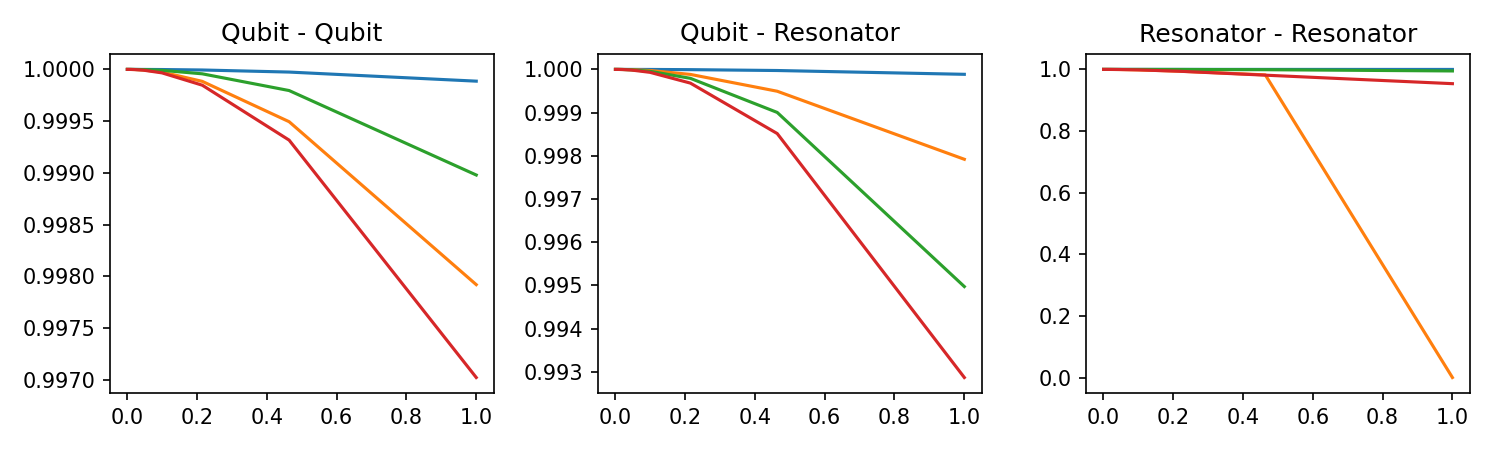

In [82]:
fig, ax = plt.subplots(ncols=3, dpi=150, figsize=[10,3])
names = ['Qubit - Qubit','Qubit - Resonator','Resonator - Resonator']

for j in range(3):
    name = names[j]

    ax[j].plot(CC_values, np.abs(Qs[j,:,0,0]))
    ax[j].plot(CC_values, np.abs(Qs[j,:,1,1]))
    ax[j].plot(CC_values, np.abs(Qs[j,:,2,2]))
    ax[j].plot(CC_values, np.abs(Qs[j,:,3,3]))
    ax[j].set_title(name)

fig.tight_layout()
fig.show()

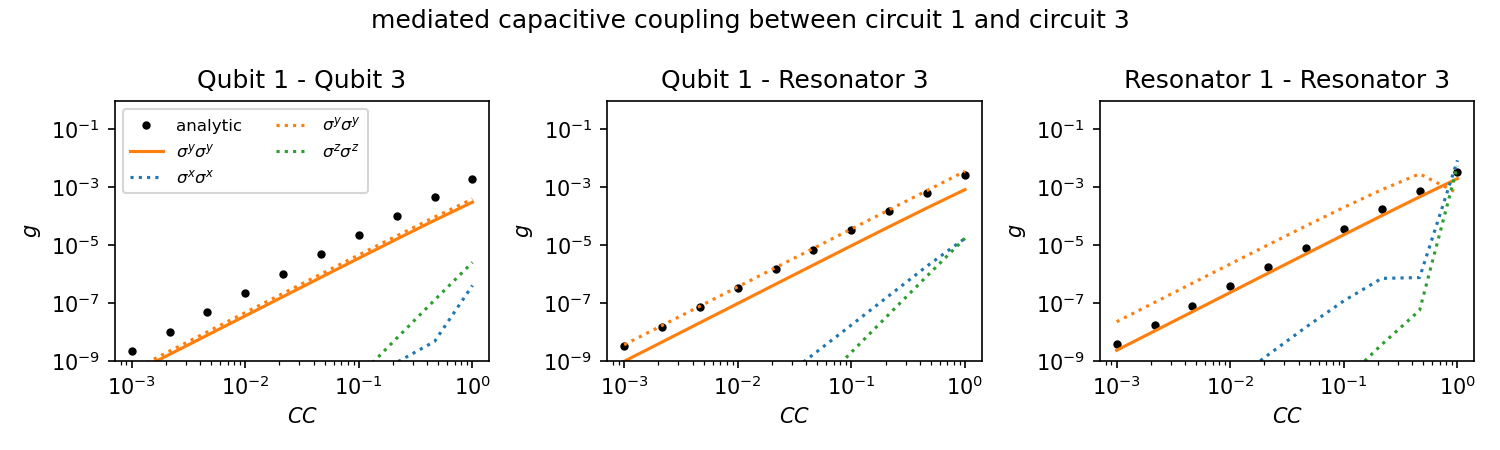

In [83]:
fig, ax = plt.subplots(ncols=3, dpi=150, figsize=[10,3])
linestyles = ['-', '--',':' ]
names = ['Qubit 1 - Qubit 3','Qubit 1 - Resonator 3','Resonator 1 - Resonator 3']
labels_list =[[r'$\sigma^x\sigma^x$',r'$\sigma^y\sigma^y$',r'$\sigma^z\sigma^z$'],
              [r'$\sigma^x\,(b^\dagger+b)$',r'$\sigma^y\,(b^\dagger-b)j$',r'$\sigma^z(2b^\dagger b-I)$'],
              [r'$(a^\dagger+a)\,(b^\dagger+b)$',r'$(a^\dagger-a)j\,(b^\dagger-b)j$',r'$(2a^\dagger a-I)(2b^\dagger b-I)$']]

for j in range(3):
    labels = labels_list[j]
    name = names[j]
    colors = figs.generate_colors_from_colormap(10, 'tab10')
    Pauli_list = [p1[j], p2[j], SWT[j]]
    
    ax[j].plot(CC_values, np.abs(g_13_analytic[j]),  '.k', label = 'analytic')
    
    for i, Pauli in enumerate(Pauli_list):
        if i ==1: 
            Pauli /= GHz
        
        σxσx = np.abs(Pauli[:, 1,1])
        σyσy = np.abs(Pauli[:, 2,2])
        σzσz = np.abs(Pauli[:, 3,3])
    
        if np.any(σxσx>1e-10):
            ax[j].plot(CC_values, σxσx,  color = colors[0], linestyle=linestyles[i], label = labels[0])
        if np.any(σyσy>1e-10):
            ax[j].plot(CC_values, σyσy,  color = colors[1], linestyle=linestyles[i], label = labels[1])
        if np.any(σzσz>1e-10):
            ax[j].plot(CC_values, σzσz,  color = colors[2], linestyle=linestyles[i], label = labels[2])
    
        if j == 0:
            ax[j].legend(ncol=2, fontsize=8)
        ax[j].set_yscale('log')
        ax[j].set_xscale('log')
        ax[j].set_ylim([1e-9,1e0])
        # ax.set_xlim([1e-2,1e1])
        ax[j].set_ylabel('$g$')
        ax[j].set_xlabel('$CC$')
        
        ax[j].set_title(name)
        
    
fig.suptitle(r'mediated capacitive coupling between circuit 1 and circuit 3')
fig.tight_layout()
# figs.export('mediated_capacitive_coupling_vs_CC_qubit_1_and_qubit_3.pdf', fig)
fig.show()

# Qubit_1 - Qubit_3, mediated by Qubit 2, vs phi_ext

In [27]:
Δs = [Δ_1, Δ_2, Δ_3]
nmax_f = 7
nmax_r = 4
φ_ext_2_values = np.linspace(0.5165,0.519,100)
CC = 0.1
n_eig_circuits=2
n_eig_qubit=4

In [28]:
φ_ext_2_values = np.concatenate([np.array([0.5]),φ_ext_2_values])

In [29]:
extra_eigs_list = [10, 20, 30]

In [30]:
p1              = np.zeros([3, len(φ_ext_2_values), 4, 4])
p2              = np.zeros([3, len(φ_ext_2_values), 4, 4])
SWT             = np.zeros([3, len(φ_ext_2_values), 4, 4])
Qs              = np.zeros([3, len(φ_ext_2_values), 4, 4], dtype='complex')
g_13_analytic   = np.zeros([3, len(φ_ext_2_values)])

C_mat = sq_ext.C_mat_qubit_C_qubit_C_qubit(CC, CF_1, CR_1, CF_2, CR_2, CF_3, CR_3)
C_inv = np.linalg.inv(C_mat)

fluxonium_1 = sq_ext.sq_fluxonium(C_F_eff=C_inv[0, 0] ** -1, L_F_eff = LF_1, EJ=EJ_1, nmax_f=nmax_f)
resonator_1 = sq_ext.sq_resonator(C_R_eff=C_inv[1, 1] ** -1, L_R_eff = LR_1, nmax_r=nmax_r)
resonator_2 = sq_ext.sq_resonator(C_R_eff=C_inv[3, 3] ** -1, L_R_eff = LR_2, nmax_r=nmax_r)
fluxonium_3 = sq_ext.sq_fluxonium(C_F_eff=C_inv[4, 4] ** -1, L_F_eff = LF_3, EJ=EJ_3, nmax_f=nmax_f)
resonator_3 = sq_ext.sq_resonator(C_R_eff=C_inv[5, 5] ** -1, L_R_eff = LR_3, nmax_r=nmax_r)

φ_ext_3_resonance = sq_ext.find_resonance(fluxonium_1.hamiltonian(), fluxonium_3)
loop_3 = fluxonium_3.loops[0]
loop_3.set_flux(φ_ext_3_resonance)

for i, φ_ext_2 in enumerate(φ_ext_2_values):
    
    print(i)
    
    fluxonium_2 = sq_ext.sq_fluxonium(C_F_eff=C_inv[2, 2] ** -1, L_F_eff = LF_2, EJ=EJ_2, nmax_f=nmax_f, φ_ext=φ_ext_2)
    if i==0:
        ω_1 = sq_ext.diag(fluxonium_1.hamiltonian(),2,remove_ground=True)[0][1]
        ω_3 = sq_ext.diag(fluxonium_3.hamiltonian(),2,remove_ground=True)[0][1]
    ω_2 = sq_ext.diag(fluxonium_2.hamiltonian(),2,remove_ground=True)[0][1]
    print(ω_1,ω_2, ω_3)
    
    circuits = [fluxonium_1, resonator_1, fluxonium_2, resonator_2, fluxonium_3, resonator_3]
    H_circuits = [circuit.hamiltonian() for circuit in circuits]
    
    H_0, H   = sq_ext.hamiltonian_qubit_C_qubit_C_qubit(C_inv, circuits, Δs, nmax_r=nmax_r, nmax_f=nmax_f, return_H_0=True)
    
    if i==0:
        H_qubit_1 = sq_ext.hamiltonian_qubit(fluxonium_1, resonator_1, Δ_1 )
        H_qubit_3 = sq_ext.hamiltonian_qubit(fluxonium_3, resonator_3, Δ_3 )
    H_qubit_2 = sq_ext.hamiltonian_qubit(fluxonium_2, resonator_2, Δ_2 )
    
    E_circuits = [sq_ext.diag(H, n_eig_circuits, solver='numpy')[0] for H in H_circuits]
    
    for j in range(2):
        ψ_0_q1, ψ_1_q1, index_0_q1, index_1_q1 = sq_ext.get_ψ_basis(basis_states_q1_list[j], H_qubit_1, E_circuits[0], E_circuits[1], nmax_f, nmax_r)
        ψ_0_q2, ψ_1_q2, index_0_q2, index_1_q2 = sq_ext.get_ψ_basis(basis_states_q2_list[j], H_qubit_2, E_circuits[2], E_circuits[3], nmax_f, nmax_r)
        ψ_0_q3, ψ_1_q3, index_0_q3, index_1_q3 = sq_ext.get_ψ_basis(basis_states_q3_list[j], H_qubit_3, E_circuits[4], E_circuits[5], nmax_f, nmax_r)
    
        ψ_00 = qt.tensor([ψ_0_q1, ψ_0_q2, ψ_0_q3])
        ψ_01 = qt.tensor([ψ_1_q1, ψ_0_q2, ψ_0_q3])
        ψ_10 = qt.tensor([ψ_0_q1, ψ_0_q2, ψ_1_q3])
        ψ_11 = qt.tensor([ψ_1_q1, ψ_0_q2, ψ_1_q3])
    
        ψ_0 = [ψ_00,ψ_01,ψ_10,ψ_11]
    
        E_0_ψ_0  = [ np.real((ψ_0_i.dag() * H_0 * ψ_0_i).data[0,0])/2/np.pi/GHz for ψ_0_i in ψ_0]
        E_0  = sq_ext.diag(H_0 , n_eig=len(ψ_0)+extra_eigs_list[j], out='GHz', solver='scipy')[0]
        print(E_0_ψ_0, E_0)
        subspace_indices = sq_ext.find_close_indices(E_0_ψ_0, E_0)
        print(subspace_indices)
        print('/n')
    
        E, ψ = sq_ext.diag(H  , n_eig=len(ψ_0)+extra_eigs_list[j], out='GHz', solver='Qutip', qObj=True)
        ψ = ψ[subspace_indices]
        E = E[subspace_indices]
        # V = H-H_0
        
        # print('Punto de control 1')
        H_eff_p1  = sq_ext.H_eff_p1_large (ψ_0, H, real=True, remove_ground=True)
        # H_eff_p2  = sq_ext.H_eff_p2_large (ψ_0, ψ, E_0, E, V,  remove_ground=True)
        H_eff_SWT, Qs[j, i,:] = sq_ext.H_eff_SWT_large(ψ_0, ψ, E, remove_ground=True,return_Q=True)
        
        p1 [j, i,:] = sq_ext.decomposition_in_pauli_4x4(H_eff_p1  ,  print_pretty=False)
        # p2 [i,:] = sq_ext.decomposition_in_pauli_4x4(H_eff_p2  ,  print_pretty=False)
        SWT[j, i,:] = sq_ext.decomposition_in_pauli_4x4(H_eff_SWT , print_pretty=False)
        
        #Analytics:
        circ_1, circ_2, circ_3 = circuits[left_index_list[j]], circuits[mediator_index_list[j]], circuits[right_index_list[j]]
        circ_1.diag(2)[0];
        circ_2.diag(2)[0];
        circ_3.diag(2)[0];
        
        Q_1 = np.abs(circ_1.charge_op(0, basis='eig')[0,1])
        Q_2 = np.abs(circ_2.charge_op(0, basis='eig')[0,1])
        Q_3 = np.abs(circ_3.charge_op(0, basis='eig')[0,1])
        
        E_1 = sq_ext.diag(H_qubit_1,4)[0]
        E_2 = sq_ext.diag(H_qubit_2,4)[0]
        E_3 = sq_ext.diag(H_qubit_3,4)[0]
        
        ω_1 = E_1[index_1_q1]- E_1[index_0_q1]
        ω_2 = E_2[index_1_q2]- E_2[index_0_q2]
        ω_3 = E_3[index_1_q3]- E_3[index_0_q3]
    
        Δ_12 = -np.abs(ω_1 - ω_2) # maybe change sign
        Δ_23 = -np.abs(ω_3 - ω_2) 
        Σ_12 = ω_1 + ω_2
        Σ_23 = ω_3 + ω_2
    
        g_12 = C_inv[left_index_list[j],mediator_index_list[j]] * fF**-1 * Q_1 * Q_2 /2/np.pi/GHz
        g_23 = C_inv[mediator_index_list[j],right_index_list[j]] * fF**-1 * Q_2 * Q_3 /2/np.pi/GHz
        g_13 = C_inv[left_index_list[j],right_index_list[j]] * fF**-1 * Q_1 * Q_3 /2/np.pi/GHz
    
        g_eff = g_12*g_23*(1/Δ_12 + 1/Δ_23 - 1/Σ_12-1/Σ_23) + g_13
    
        g_13_analytic[j, i] = g_eff


0
3.6873854541203954 3.4194564688415454 3.687420884851554
[15.13924630691387, 18.81658637626493, 18.782732742946475, 22.460072812297536] [15.139246306914 18.556499532185 18.782732742947 18.816586376265 20.388706143690 21.390338211576 21.594996711691 22.199985968217 22.233839601536 22.460072812298 22.858232947433 23.208120048129 23.632863618415 23.805959368960]
[0, 3, 2, 9]
/n
[15.13924630691387, 18.81658637626493, 20.38870614368929, 24.066046213040334] [15.139246306914 18.556499532185 18.782732742947 18.816586376265 20.388706143690 21.390338211576 21.594996711691 22.199985968217 22.233839601536 22.460072812298 22.858232947433 23.208120048129 23.632863618415 23.805959368960 24.057295259432 24.066046213041 24.810768753579 25.012249936962
 25.033824647608 25.067678280926 25.238483147723 25.275587063426 25.638720755959 25.877326037568]
[0, 3, 4, 15]
/n
1
3.6773400693511142 3.63007117605634 3.6434864360326524
[14.986562623088002, 18.66390269243917, 18.63004905912059, 22.3073891284717] [14.9

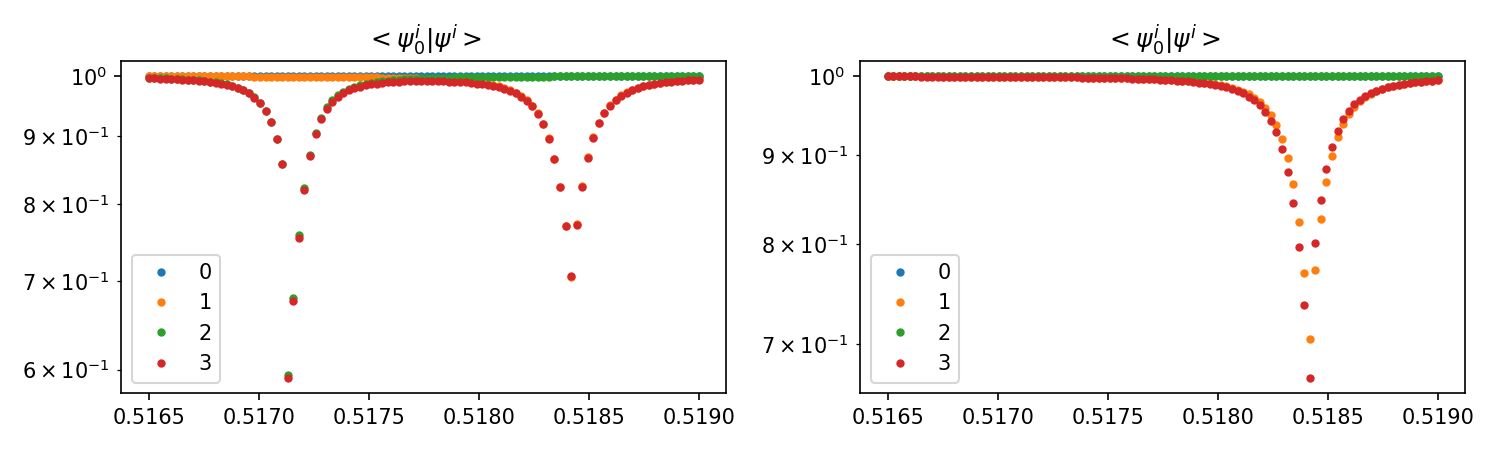

In [34]:
fig, ax = plt.subplots(ncols=2, figsize=[10,3], dpi=150)

for j in range(2):
    ax[j].plot(φ_ext_2_values[1:], np.abs(Qs[j, 1:,0,0]),'.', label='0')
    ax[j].plot(φ_ext_2_values[1:], np.abs(Qs[j, 1:,1,1]),'.', label='1')
    ax[j].plot(φ_ext_2_values[1:], np.abs(Qs[j, 1:,2,2]),'.', label='2')
    ax[j].plot(φ_ext_2_values[1:], np.abs(Qs[j, 1:,3,3]),'.', label='3')
    ax[j].set_yscale('log')
    ax[j].legend()
    ax[j].set_title(r'$<ψ_0^i|ψ^i>$') 

fig.tight_layout()
fig.show()

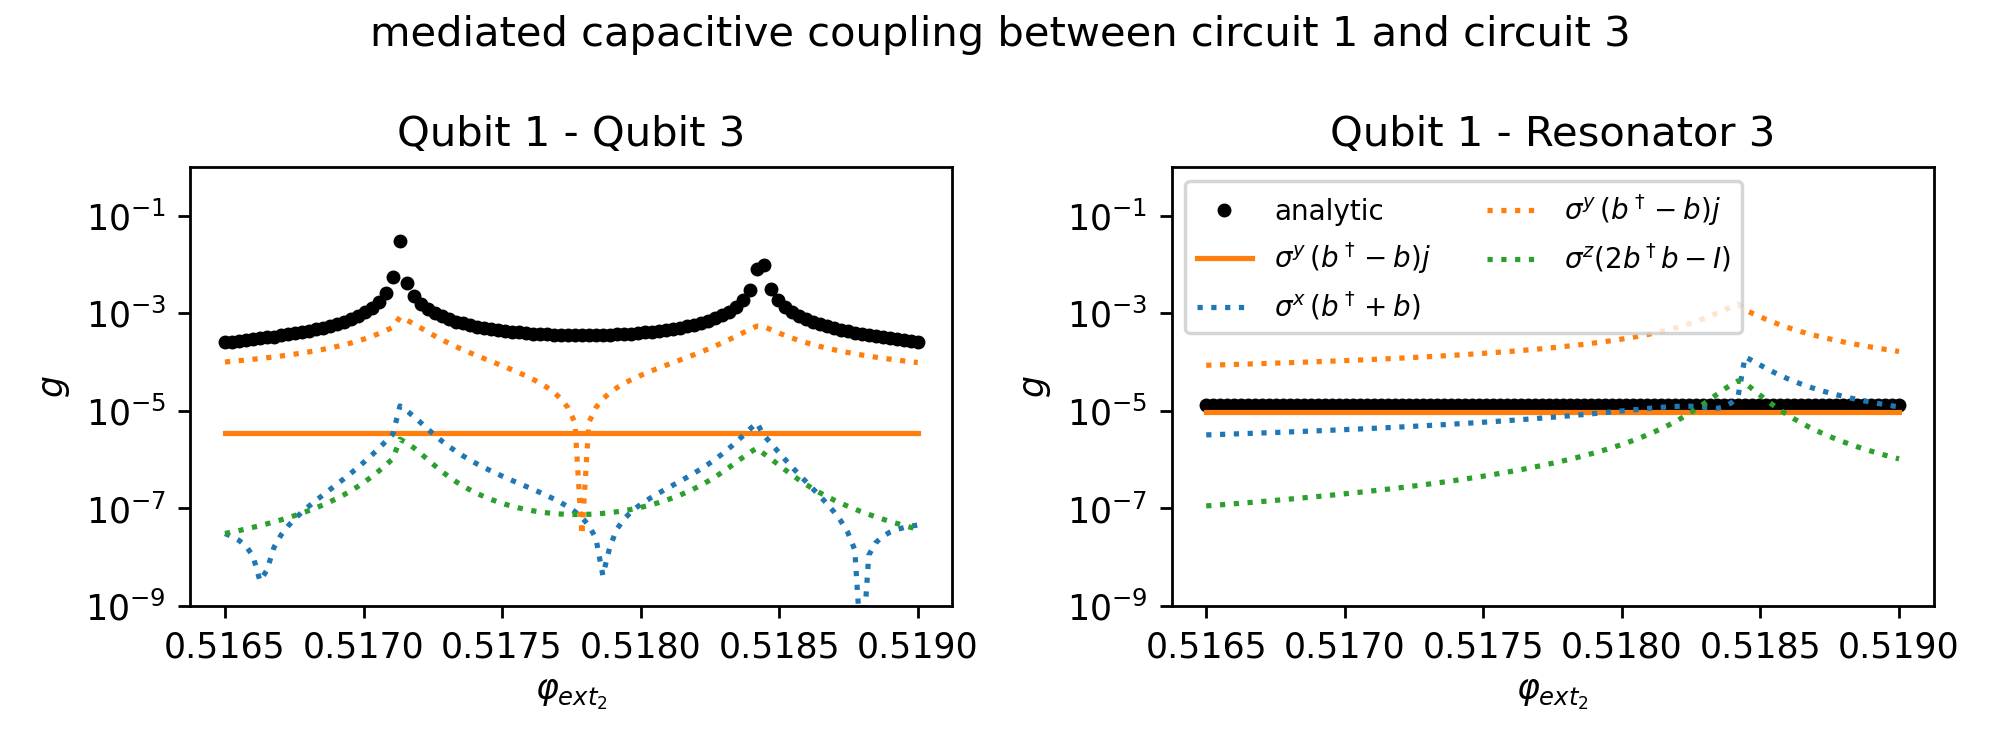

In [44]:
fig, ax = plt.subplots(ncols=2, dpi=250, figsize=[8,3])
linestyles = ['-', '--',':' ]
names = ['Qubit 1 - Qubit 3','Qubit 1 - Resonator 3','Resonator 1 - Resonator 3']
labels_list =[[r'$\sigma^x\sigma^x$',r'$\sigma^y\sigma^y$',r'$\sigma^z\sigma^z$'],
              [r'$\sigma^x\,(b^\dagger+b)$',r'$\sigma^y\,(b^\dagger-b)j$',r'$\sigma^z(2b^\dagger b-I)$'],
              [r'$(a^\dagger+a)\,(b^\dagger+b)$',r'$(a^\dagger-a)j\,(b^\dagger-b)j$',r'$(2a^\dagger a-I)(2b^\dagger b-I)$']]

for j in range(2):
    labels = labels_list[j]
    name = names[j]
    colors = figs.generate_colors_from_colormap(10, 'tab10')
    Pauli_list = [p1[j], p2[j], SWT[j]]
    
    ax[j].plot(φ_ext_2_values[1:], np.abs(g_13_analytic[j,1:]),  '.k', label = 'analytic')
    
    for i, Pauli in enumerate(Pauli_list):
        if i ==1: 
            Pauli /= GHz
        
        σxσx = np.abs(Pauli[:, 1,1])
        σyσy = np.abs(Pauli[:, 2,2])
        σzσz = np.abs(Pauli[:, 3,3])
    
        if np.any(σxσx>1e-10):
            ax[j].plot(φ_ext_2_values[1:], σxσx[1:],  color = colors[0], linestyle=linestyles[i], label = labels[0])
        if np.any(σyσy>1e-10):
            ax[j].plot(φ_ext_2_values[1:], σyσy[1:],  color = colors[1], linestyle=linestyles[i], label = labels[1])
        if np.any(σzσz>1e-10):
            ax[j].plot(φ_ext_2_values[1:], σzσz[1:],  color = colors[2], linestyle=linestyles[i], label = labels[2])
    
        if j == 1:
            ax[j].legend(ncol=2, fontsize=8)
        ax[j].set_yscale('log')
        # ax[j].set_xscale('log')
        ax[j].set_ylim([1e-9,1e0])
        # ax.set_xlim([1e-2,1e1])
        ax[j].set_ylabel('$g$')
        ax[j].set_xlabel(r'$\varphi_{ext_2}$')
        
        ax[j].set_title(name)
        
    
fig.suptitle(r'mediated capacitive coupling between circuit 1 and circuit 3')
fig.tight_layout()
# figs.export('mediated_capacitive_coupling_vs_CC_qubit_1_and_qubit_3.pdf', fig)
fig.show()

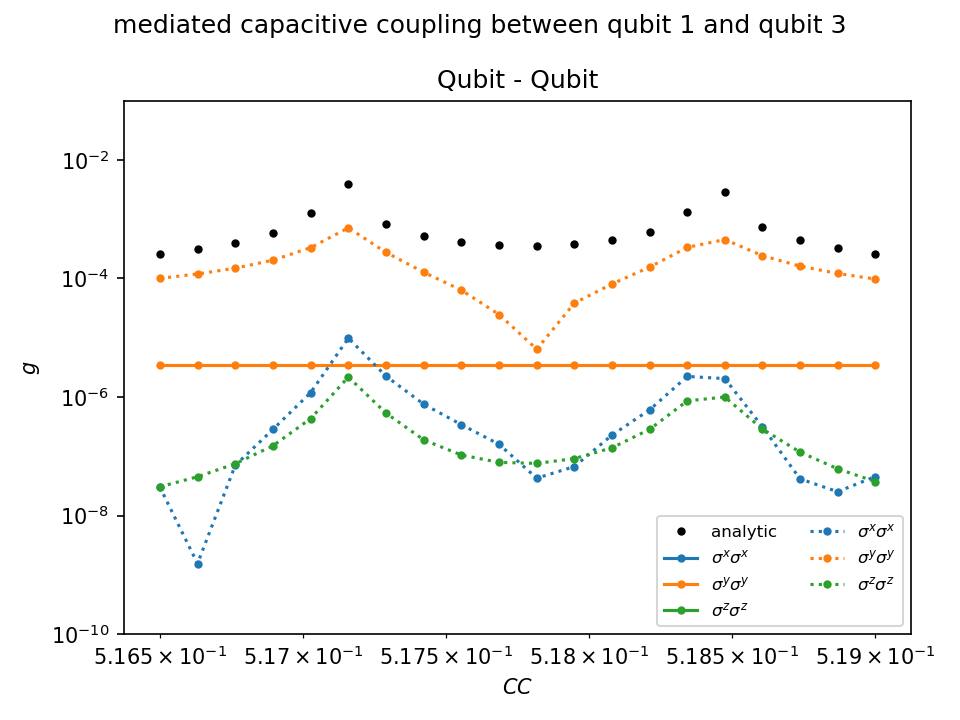

In [41]:
fig, ax = plt.subplots(dpi=150)
linestyles = ['-', '--',':' ]
names = ['Qubit - Qubit','Qubit - Resonator','Resonator - Resonator']
labels_list =[[r'$\sigma^x\sigma^x$',r'$\sigma^y\sigma^y$',r'$\sigma^z\sigma^z$'],
              [r'$\sigma^x\,(b^\dagger+b)$',r'$\sigma^y\,(b^\dagger-b)j$',r'$\sigma^z(2b^\dagger b-I)$'],
              [r'$(a^\dagger+a)\,(b^\dagger+b)$',r'$(a^\dagger-a)j\,(b^\dagger-b)j$',r'$(2a^\dagger a-I)(2b^\dagger b-I)$']]

labels = labels_list[0]
name = names[0]
colors = figs.generate_colors_from_colormap(10, 'tab10')
Pauli_list = [p1, p2, SWT]

ax.plot(φ_ext_2_values[1:], np.abs(g_13_analytic)[1:],  '.k', label = 'analytic')

for i, Pauli in enumerate(Pauli_list):
    if i ==1: 
        continue
        # Pauli /= GHz 
    
    σxσx = np.abs(Pauli[:, 1,1])
    σyσy = np.abs(Pauli[:, 2,2])
    σzσz = np.abs(Pauli[:, 3,3])

    ax.plot(φ_ext_2_values[1:], σxσx[1:], '.' , color = colors[0], linestyle=linestyles[i], label = labels[0])
    ax.plot(φ_ext_2_values[1:], σyσy[1:], '.' , color = colors[1], linestyle=linestyles[i], label = labels[1])
    ax.plot(φ_ext_2_values[1:], σzσz[1:], '.' , color = colors[2], linestyle=linestyles[i], label = labels[2])
    
    ax.legend(ncol=2, fontsize=8)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim([1e-10,1e-1])
    # ax.set_xlim([1e-2,1e1])
    ax.set_ylabel('$g$')
    ax.set_xlabel(r'$\varphi_{ext_2}$')
    
    ax.set_title(name)
    
fig.suptitle(r'mediated capacitive coupling between qubit 1 and qubit 3')
fig.tight_layout()
# figs.export('mediated_capacitive_coupling_vs_CC_qubit_1_and_qubit_3.pdf', fig)
fig.show()

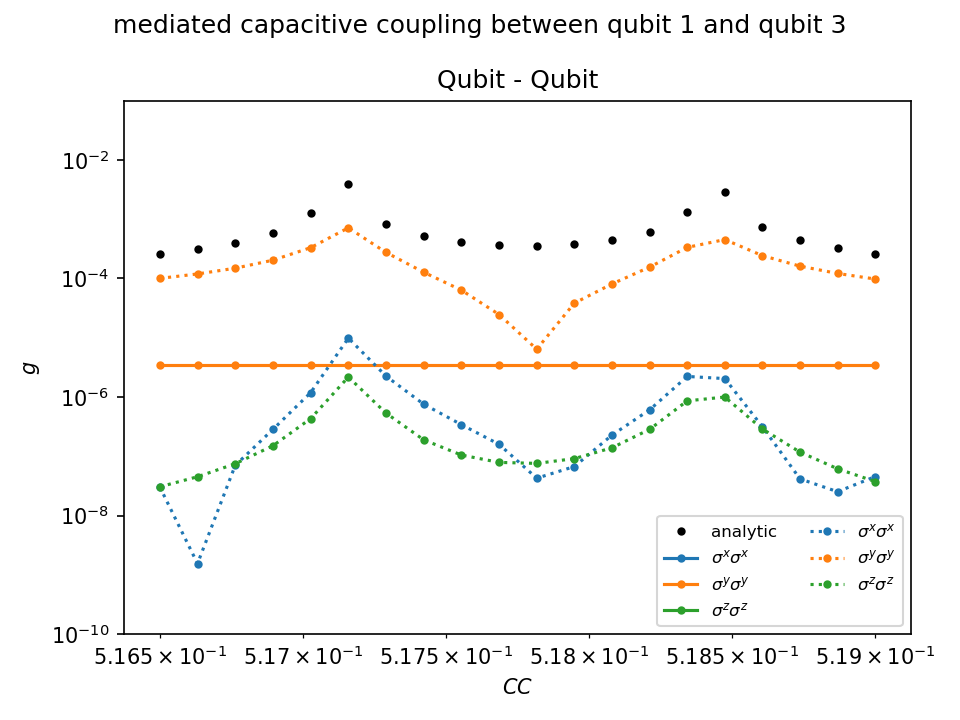

In [30]:
fig, ax = plt.subplots(dpi=150)
linestyles = ['-', '--',':' ]
names = ['Qubit - Qubit','Qubit - Resonator','Resonator - Resonator']
labels_list =[[r'$\sigma^x\sigma^x$',r'$\sigma^y\sigma^y$',r'$\sigma^z\sigma^z$'],
              [r'$\sigma^x\,(b^\dagger+b)$',r'$\sigma^y\,(b^\dagger-b)j$',r'$\sigma^z(2b^\dagger b-I)$'],
              [r'$(a^\dagger+a)\,(b^\dagger+b)$',r'$(a^\dagger-a)j\,(b^\dagger-b)j$',r'$(2a^\dagger a-I)(2b^\dagger b-I)$']]

labels = labels_list[0]
name = names[0]
colors = figs.generate_colors_from_colormap(10, 'tab10')
Pauli_list = [p1, p2, SWT]

ax.plot(φ_ext_2_values[1:], np.abs(g_13_analytic)[1:],  '.k', label = 'analytic')

for i, Pauli in enumerate(Pauli_list):
    if i ==1: 
        continue
        # Pauli /= GHz 
    
    σxσx = np.abs(Pauli[:, 1,1])
    σyσy = np.abs(Pauli[:, 2,2])
    σzσz = np.abs(Pauli[:, 3,3])

    ax.plot(φ_ext_2_values[1:], σxσx[1:], '.' , color = colors[0], linestyle=linestyles[i], label = labels[0])
    ax.plot(φ_ext_2_values[1:], σyσy[1:], '.' , color = colors[1], linestyle=linestyles[i], label = labels[1])
    ax.plot(φ_ext_2_values[1:], σzσz[1:], '.' , color = colors[2], linestyle=linestyles[i], label = labels[2])
    
    ax.legend(ncol=2, fontsize=8)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim([1e-10,1e-1])
    # ax.set_xlim([1e-2,1e1])
    ax.set_ylabel('$g$')
    ax.set_xlabel('$CC$')
    
    ax.set_title(name)
    
fig.suptitle(r'mediated capacitive coupling between qubit 1 and qubit 3')
fig.tight_layout()
# figs.export('mediated_capacitive_coupling_vs_CC_qubit_1_and_qubit_3.pdf', fig)
fig.show()

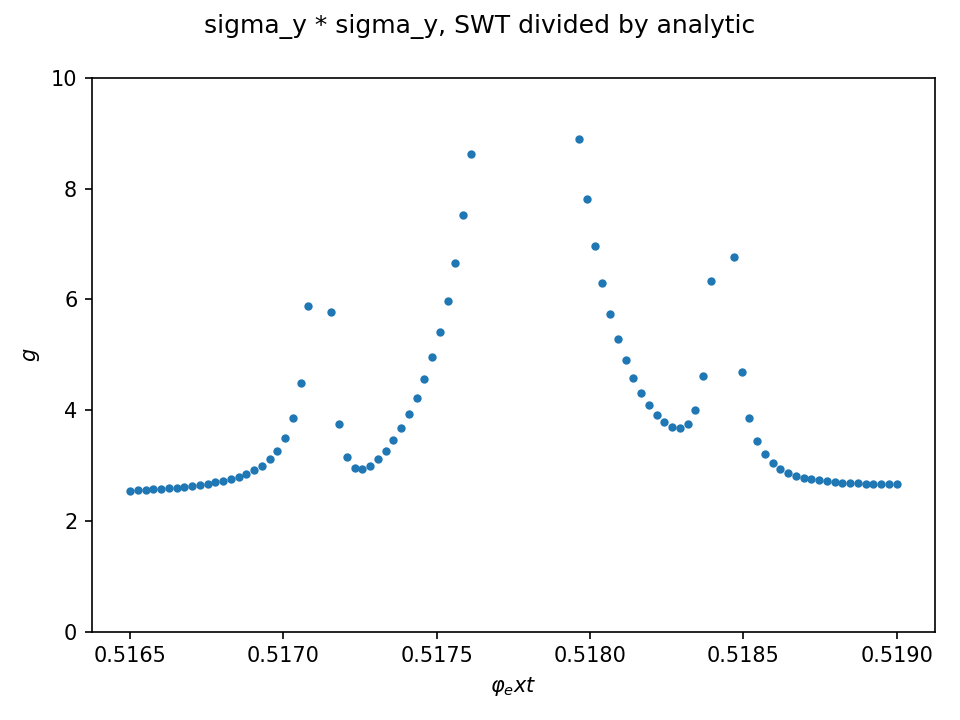

In [329]:
fig, ax = plt.subplots(dpi=150)

ax.plot(φ_ext_2_values[1:], (σyσy[1:]/np.abs(g_13_analytic[1:]))**-1, '.')
ax.set_ylim([0,10])
ax.set_ylabel('$g$')
ax.set_xlabel(r'$\varphi_ext$')

fig.suptitle(r'sigma_y * sigma_y, SWT divided by analytic')
fig.tight_layout()
fig.show()

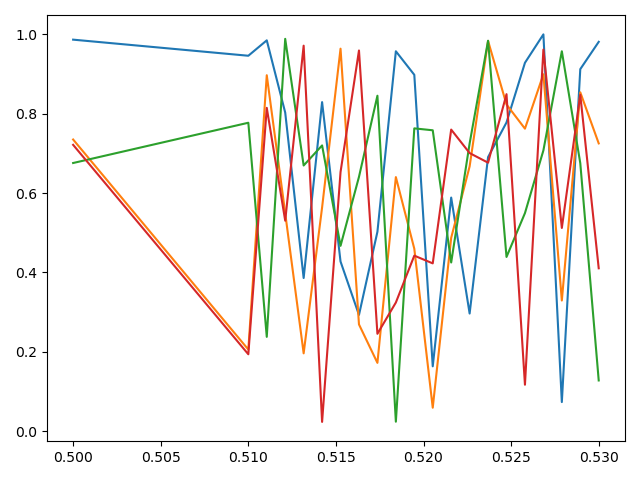

In [180]:
fig, ax = plt.subplots()

ax.plot(φ_ext_2_values, np.abs(Qs[:,0,0]))
ax.plot(φ_ext_2_values, np.abs(Qs[:,1,1]))
ax.plot(φ_ext_2_values, np.abs(Qs[:,2,2]))
ax.plot(φ_ext_2_values, np.abs(Qs[:,3,3]))
fig.tight_layout()
fig.show()

In [176]:
np.diag(Qs)

ValueError: Input must be 1- or 2-d.

In [383]:
φ_ext_2=0.5185

In [380]:
H_eff_p1 = []
H_eff_SWT = []

In [384]:
fluxonium_1 = sq_ext.sq_fluxonium(C_F_eff=C_inv[0, 0] ** -1, L_F_eff = LF_1, EJ=EJ_1, nmax_f=nmax_f)
resonator_1 = sq_ext.sq_resonator(C_R_eff=C_inv[1, 1] ** -1, L_R_eff = LR_1, nmax_r=nmax_r)
fluxonium_2 = sq_ext.sq_fluxonium(C_F_eff=C_inv[2, 2] ** -1, L_F_eff = LF_2, EJ=EJ_2, nmax_f=nmax_f, φ_ext=φ_ext_2)
resonator_2 = sq_ext.sq_resonator(C_R_eff=C_inv[3, 3] ** -1, L_R_eff = LR_2, nmax_r=nmax_r)
fluxonium_3 = sq_ext.sq_fluxonium(C_F_eff=C_inv[4, 4] ** -1, L_F_eff = LF_3, EJ=EJ_3, nmax_f=nmax_f)
resonator_3 = sq_ext.sq_resonator(C_R_eff=C_inv[5, 5] ** -1, L_R_eff = LR_3, nmax_r=nmax_r)

φ_ext_3_resonance = sq_ext.find_resonance(fluxonium_1.hamiltonian(), fluxonium_3)
loop_3 = fluxonium_3.loops[0]
loop_3.set_flux(φ_ext_3_resonance)


ω_1 = sq_ext.diag(fluxonium_1.hamiltonian(),2,remove_ground=True)[0][1]
ω_2 = sq_ext.diag(fluxonium_2.hamiltonian(),2,remove_ground=True)[0][1]
ω_3 = sq_ext.diag(fluxonium_3.hamiltonian(),2,remove_ground=True)[0][1]
print(ω_1,ω_2, ω_3)

circuits = [fluxonium_1, resonator_1, fluxonium_2, resonator_2, fluxonium_3, resonator_3]
H_circuits = [circuit.hamiltonian() for circuit in circuits]

H_0, H   = sq_ext.hamiltonian_qubit_C_qubit_C_qubit(C_inv, circuits, Δs, nmax_r=nmax_r, nmax_f=nmax_f, return_H_0=True)

# if i ==0: 
H_qubit_1 = sq_ext.hamiltonian_qubit(fluxonium_1, resonator_1, Δ_1 )
H_qubit_2 = sq_ext.hamiltonian_qubit(fluxonium_2, resonator_2, Δ_2 )
H_qubit_3 = sq_ext.hamiltonian_qubit(fluxonium_3, resonator_3, Δ_3 )

E_q1, ψ_q1 = sq_ext.diag(H_qubit_1, n_eig_qubit, solver='numpy')
E_q2, ψ_q2 = sq_ext.diag(H_qubit_2, n_eig_qubit, solver='numpy')
E_q3, ψ_q3 = sq_ext.diag(H_qubit_3, n_eig_qubit, solver='numpy')

E_circuits = [sq_ext.diag(H, n_eig_circuits, solver='numpy')[0] for H in H_circuits]

# Nf, Nr = sq_ext.sq_get_energy_indices_hamiltonian(H_qubit = H_qubit_1, H_fluxonium=H_circuits[0], H_resonator=H_circuits[1], n_eig=2)
Nf, Nr = sq_ext.sq_get_energy_indices(E_q1, E_circuits[0], E_circuits[1])
subspace_indices = np.intersect1d(np.where(Nf<=1), np.where(Nr==0)).tolist()
index_00_q1 = np.intersect1d(np.where(Nf==0), np.where(Nr==0)).tolist()[0]
index_10_q1 = np.intersect1d(np.where(Nf==1), np.where(Nr==0)).tolist()[0]

# Nf, Nr = sq_ext.sq_get_energy_indices_hamiltonian(H_qubit = H_qubit_2, H_fluxonium=H_circuits[2], H_resonator=H_circuits[3], n_eig=2)
Nf, Nr = sq_ext.sq_get_energy_indices(E_q2, E_circuits[2], E_circuits[3])
subspace_indices = np.intersect1d(np.where(Nf<=1), np.where(Nr==0)).tolist()
index_00_q2 = np.intersect1d(np.where(Nf==0), np.where(Nr==0)).tolist()[0]
index_10_q2 = np.intersect1d(np.where(Nf==1), np.where(Nr==0)).tolist()[0]

# Nf, Nr = sq_ext.sq_get_energy_indices_hamiltonian(H_qubit = H_qubit_3, H_fluxonium=H_circuits[4], H_resonator=H_circuits[5], n_eig=2)
Nf, Nr = sq_ext.sq_get_energy_indices(E_q3, E_circuits[4], E_circuits[5])
subspace_indices = np.intersect1d(np.where(Nf<=1), np.where(Nr==0)).tolist()
index_00_q3 = np.intersect1d(np.where(Nf==0), np.where(Nr==0)).tolist()[0]
index_10_q3 = np.intersect1d(np.where(Nf==1), np.where(Nr==0)).tolist()[0]

ψ_00_q1 = qt.Qobj(ψ_q1[:,index_00_q1]) 
ψ_10_q1 = qt.Qobj(ψ_q1[:,index_10_q1]) 
ψ_00_q2 = qt.Qobj(ψ_q2[:,index_00_q2]) 
ψ_10_q2 = qt.Qobj(ψ_q2[:,index_10_q2]) 
ψ_00_q3 = qt.Qobj(ψ_q3[:,index_00_q3]) 
ψ_10_q3 = qt.Qobj(ψ_q3[:,index_10_q3]) 

ψ_00_q1.dims = [[nmax_f, nmax_r],[1,1]]
ψ_10_q1.dims = [[nmax_f, nmax_r],[1,1]]
ψ_00_q2.dims = [[nmax_f, nmax_r],[1,1]]
ψ_10_q2.dims = [[nmax_f, nmax_r],[1,1]]
ψ_00_q3.dims = [[nmax_f, nmax_r],[1,1]]
ψ_10_q3.dims = [[nmax_f, nmax_r],[1,1]]

ψ_00 = qt.tensor([ψ_00_q1, ψ_00_q2, ψ_00_q3])
ψ_01 = qt.tensor([ψ_10_q1, ψ_00_q2, ψ_00_q3])
ψ_10 = qt.tensor([ψ_00_q1, ψ_00_q2, ψ_10_q3])
ψ_11 = qt.tensor([ψ_10_q1, ψ_00_q2, ψ_10_q3])

ψ_0 = [ψ_00,ψ_01,ψ_10,ψ_11]

E_0_ψ_0  = [ np.real((ψ_0_i.dag() * H_0 * ψ_0_i).data[0,0])/2/np.pi/GHz for ψ_0_i in ψ_0]
E_0  = sq_ext.diag(H_0 , n_eig=len(ψ_0)+6, out='GHz', solver='scipy')[0]
subspace_indices = sq_ext.find_close_indices(E_0_ψ_0, E_0)
print(E_0_ψ_0, E_0)
print(subspace_indices)
print('/n')

E, ψ = sq_ext.diag(H  , n_eig=len(ψ_0)+6, out='GHz', solver='Qutip', qObj=True)
ψ = ψ[subspace_indices]
E = E[subspace_indices]
# V = H-H_0

# print('Punto de control 1')
H_eff_p1.append( sq_ext.H_eff_p1_large (ψ_0, H, real=False, remove_ground=True) )
# H_eff_p2  = sq_ext.H_eff_p2_large (ψ_0, ψ, E_0, E, V,  remove_ground=True)
H_eff_SWT.append( sq_ext.H_eff_SWT_large(ψ_0, ψ, E, remove_ground=True) )

3.6873854541203803 3.681254572271679 3.6874208848515653
[14.948750574933943, 18.626090667521094, 18.592241538006757, 22.269581630593983] [14.948750574934 18.592241538007 18.626090667522 18.627881250732 20.198394547304 21.199864609130 21.404506417584 22.269581630595 22.271372213805 22.305221343319]
[0, 2, 1, 7]
/n
